<a href="https://colab.research.google.com/github/saikumarbysani/PortFolioProject/blob/main/Project_Churn_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import modules we need for EDA and wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# these functions are useful for splitting and normalization
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# regression error metrics - scikit-learn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# regression error metrics - scikit-learn
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.eval_measures import meanabs

# Some tests/statistics required for validating assumptions
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

# import other functions we'll need for classification modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# import functions for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# classification error metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# And this function to help with the normaliztion when doing cross validation
from sklearn.pipeline import Pipeline

In [ ]:
pip install pyxlsb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Reading the dataframe containing the features

In [ ]:
df=pd.read_excel('/content/drive/MyDrive/ChurnData.xlsb')

In [ ]:
pd.set_option('display.max_columns', None)

### Changing the data type of categorical features from int,float to object

In [ ]:
df['month'] = df.month.astype(object)

In [ ]:
df['user_account_id'] = df.user_account_id.astype(object)

In [ ]:
df['user_intake'] = df.user_intake.astype(object)

In [ ]:
df['user_has_outgoing_calls'] = df.user_has_outgoing_calls.astype(object)

In [ ]:
df['user_has_outgoing_sms'] = df.user_has_outgoing_sms.astype(object)

In [ ]:
df['user_use_gprs'] = df.user_use_gprs.astype(object)

In [ ]:
df['user_does_reload'] = df.user_does_reload.astype(object)

### Data Types of all features

In [ ]:
df.dtypes

year                                       int64
month                                     object
user_account_id                           object
user_lifetime                              int64
user_intake                               object
                                          ...   
last_100_sms_outgoing_count                int64
last_100_sms_outgoing_to_onnet_count       int64
last_100_sms_outgoing_to_offnet_count      int64
last_100_sms_outgoing_to_abroad_count      int64
last_100_gprs_usage                      float64
Length: 65, dtype: object

### Creating a list of all categorical features in the data set

In [ ]:
# getting all the categorical features in the data
cat_feat = [feature for feature in df.columns if df[feature].dtypes=='O']

###Creating a list of all the numeric features in the data set

In [ ]:
# getting all the numerical features in the data
num_feat = list(df.drop(cat_feat, axis=1).columns)


###Creating a data frame which is a subset of the entire data where month is 6, with user_account_id_6 as index.

In [ ]:
df_6=df[df['month']==6]

In [ ]:
df_6.shape

(57656, 65)

In [ ]:
df_6.columns = df_6.columns.values + '_6'


In [ ]:
df_6_new=df_6.set_index('user_account_id_6')

In [ ]:
df_6_new.shape

(57656, 64)

###Creating a data frame which is a subset of the entire data where month is 7, with user_account_id_7 as the index.

In [ ]:
df_7=df[df['month']==7]

In [ ]:
df_7.shape

(58218, 65)

In [ ]:
df_7.columns = df_7.columns.values + '_7'


In [ ]:
df_7_new=df_7.set_index('user_account_id_7')

In [ ]:
df_7_new.shape

(58218, 64)

###Creating a data frame which is a subset of the entire data where month is 8, with user_account_id_8 as the index.

In [ ]:
df_8=df[df['month']==8]

In [ ]:
df_8.shape

(66469, 65)

In [ ]:
df_8.columns = df_8.columns.values + '_8'

In [ ]:
df_8_new=df_8.set_index('user_account_id_8')

In [ ]:
df_8_new.shape

(66469, 64)

### Concatinating all the created data frames above.

In [ ]:
df_new = pd.concat([df_6_new,df_7_new,df_8_new], axis=1, join='outer')
display(df_new)

year_6 month_6  user_lifetime_6 user_intake_6  \
13       2013.0       6           1000.0             0   
14       2013.0       6           1000.0             0   
18       2013.0       6           1005.0             0   
27       2013.0       6           1013.0             0   
32       2013.0       6           1032.0             0   
...         ...     ...              ...           ...   
1196937     NaN     NaN              NaN           NaN   
1196938     NaN     NaN              NaN           NaN   
1196939     NaN     NaN              NaN           NaN   
1196940     NaN     NaN              NaN           NaN   
1196944     NaN     NaN              NaN           NaN   

         user_no_outgoing_activity_in_days_6  user_account_balance_last_6  \
13                                       1.0                         0.05   
14                                      25.0                        28.31   
18                                       8.0                        15.62   
27                                      11.0                         5.62   
32                                       2.0                         5.86   
...                                      ...                          ...   
1196937                                  NaN                          NaN   
1196938                                  NaN                          NaN   
1196939                                  NaN                          NaN   
1196940                                  NaN                          NaN   
1196944                                  NaN                          NaN   

         user_spendings_6 user_has_outgoing_calls_6 user_has_outgoing_sms_6  \
13                   0.00                         1                       1   
14                   3.45                         1                       0   
18                   1.97                         1                       0   
27                   0.00                         1                       0   
32                   0.15                         1                       0   
...                   ...                       ...                     ...   
1196937               NaN                       NaN                     NaN   
1196938               NaN                       NaN                     NaN   
1196939               NaN                       NaN                     NaN   
1196940               NaN                       NaN                     NaN   
1196944               NaN                       NaN                     NaN   

        user_use_gprs_6 user_does_reload_6  reloads_inactive_days_6  \
13                    0                  0                     66.0   
14                    0                  0                   1276.0   
18                    0                  0                   1276.0   
27                    0                  0                   1276.0   
32                    0                  1                     17.0   
...                 ...                ...                      ...   
1196937             NaN                NaN                      NaN   
1196938             NaN                NaN                      NaN   
1196939             NaN                NaN                      NaN   
1196940             NaN                NaN                      NaN   
1196944             NaN                NaN                      NaN   

         reloads_count_6  reloads_sum_6  calls_outgoing_count_6  \
13                   0.0            0.0                    27.0   
14                   0.0            0.0                     5.0   
18                   0.0            0.0                    18.0   
27                   0.0            0.0                     1.0   
32                   1.0            6.0                    22.0   
...                  ...            ...                     ...   
1196937              NaN            NaN                     NaN   
1196938              NaN            NaN          

### Reading the dataset containing the target variable

In [ ]:
xls = pd.ExcelFile('/content/drive/MyDrive/ChurnData.xlsb')
df1 = pd.read_excel(xls, 'Customer_churners')

In [ ]:
df2=df1.drop(['year','month'],axis=1)

In [ ]:
df2

user_account_id  churn
0               376265      0
1              1151965      0
2              1186430      0
3              1036474      0
4               934461      0
...                ...    ...
66464           403311      0
66465            18806      0
66466           346074      0
66467            17385      0
66468           989825      0

[66469 rows x 2 columns]

In [ ]:
df2=df2.set_index('user_account_id')

### Concatinating the features with the target variable.

In [ ]:
df_new = pd.concat([df_new,df2], axis=1, join='inner')
display(df_new)

year_6 month_6  user_lifetime_6 user_intake_6  \
13       2013.0       6           1000.0             0   
14       2013.0       6           1000.0             0   
18       2013.0       6           1005.0             0   
27       2013.0       6           1013.0             0   
32       2013.0       6           1032.0             0   
...         ...     ...              ...           ...   
1196937     NaN     NaN              NaN           NaN   
1196938     NaN     NaN              NaN           NaN   
1196939     NaN     NaN              NaN           NaN   
1196940     NaN     NaN              NaN           NaN   
1196944     NaN     NaN              NaN           NaN   

         user_no_outgoing_activity_in_days_6  user_account_balance_last_6  \
13                                       1.0                         0.05   
14                                      25.0                        28.31   
18                                       8.0                        15.62   
27                                      11.0                         5.62   
32                                       2.0                         5.86   
...                                      ...                          ...   
1196937                                  NaN                          NaN   
1196938                                  NaN                          NaN   
1196939                                  NaN                          NaN   
1196940                                  NaN                          NaN   
1196944                                  NaN                          NaN   

         user_spendings_6 user_has_outgoing_calls_6 user_has_outgoing_sms_6  \
13                   0.00                         1                       1   
14                   3.45                         1                       0   
18                   1.97                         1                       0   
27                   0.00                         1                       0   
32                   0.15                         1                       0   
...                   ...                       ...                     ...   
1196937               NaN                       NaN                     NaN   
1196938               NaN                       NaN                     NaN   
1196939               NaN                       NaN                     NaN   
1196940               NaN                       NaN                     NaN   
1196944               NaN                       NaN                     NaN   

        user_use_gprs_6 user_does_reload_6  reloads_inactive_days_6  \
13                    0                  0                     66.0   
14                    0                  0                   1276.0   
18                    0                  0                   1276.0   
27                    0                  0                   1276.0   
32                    0                  1                     17.0   
...                 ...                ...                      ...   
1196937             NaN                NaN                      NaN   
1196938             NaN                NaN                      NaN   
1196939             NaN                NaN                      NaN   
1196940             NaN                NaN                      NaN   
1196944             NaN                NaN                      NaN   

         reloads_count_6  reloads_sum_6  calls_outgoing_count_6  \
13                   0.0            0.0                    27.0   
14                   0.0            0.0                     5.0   
18                   0.0            0.0                    18.0   
27                   0.0            0.0                     1.0   
32                   1.0            6.0                    22.0   
...                  ...            ...                     ...   
1196937              NaN            NaN                     NaN   
1196938              NaN            NaN          

In [ ]:
df_new=df_new.drop(['year_6','month_6','year_7','month_7','year_8','month_8'],axis=1)

### Creating lists containing the continuous and categorical variables from the new dataset.

In [ ]:
num_feat=list(df_new.select_dtypes(['float64','int64']).columns)
cat_feat=list(df_new.select_dtypes('object').columns)

In [ ]:
cat_feat

['user_intake_6',
 'user_has_outgoing_calls_6',
 'user_has_outgoing_sms_6',
 'user_use_gprs_6',
 'user_does_reload_6',
 'user_intake_7',
 'user_has_outgoing_calls_7',
 'user_has_outgoing_sms_7',
 'user_use_gprs_7',
 'user_does_reload_7',
 'user_intake_8',
 'user_has_outgoing_calls_8',
 'user_has_outgoing_sms_8',
 'user_use_gprs_8',
 'user_does_reload_8']

### Creating a dataframe containing only continuous variables and also imputing the missing values of all the continuous variables with the median.
* We choose median instead of mean because there are many extreme values which will affect the mean.

In [ ]:
column=list(df_new.select_dtypes(['int64','float64']).columns)
df_new[column] = df_new[column].fillna(df_new[column].median())

### Creating a dataframe containing only categorical features.

In [ ]:
column_cat=list(df_new.select_dtypes(['object']).columns)
df_cat=df_new[column_cat]

In [ ]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66469 entries, 13 to 1196944
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   user_intake_6              57656 non-null  object
 1   user_has_outgoing_calls_6  57656 non-null  object
 2   user_has_outgoing_sms_6    57656 non-null  object
 3   user_use_gprs_6            57656 non-null  object
 4   user_does_reload_6         57656 non-null  object
 5   user_intake_7              58218 non-null  object
 6   user_has_outgoing_calls_7  58218 non-null  object
 7   user_has_outgoing_sms_7    58218 non-null  object
 8   user_use_gprs_7            58218 non-null  object
 9   user_does_reload_7         58218 non-null  object
 10  user_intake_8              66469 non-null  object
 11  user_has_outgoing_calls_8  66469 non-null  object
 12  user_has_outgoing_sms_8    66469 non-null  object
 13  user_use_gprs_8            66469 non-null  object
 14  use

### User_df

In [ ]:
user_df=df_new[['user_lifetime_6','user_no_outgoing_activity_in_days_6',
                  'user_account_balance_last_6','user_spendings_6',
                'user_lifetime_7','user_no_outgoing_activity_in_days_7',
                  'user_account_balance_last_7','user_spendings_7',
                'user_lifetime_8','user_no_outgoing_activity_in_days_8',
                  'user_account_balance_last_8','user_spendings_8']]

In [ ]:
column=user_df.columns
user_df[column] = user_df[column].fillna(user_df[column].median())

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### reloads_df

In [ ]:
reloads_df=df_new[['reloads_inactive_days_6','reloads_count_6','reloads_sum_6',
                   'reloads_inactive_days_7','reloads_count_7','reloads_sum_7',
                   'reloads_inactive_days_8','reloads_count_8','reloads_sum_8']]

In [ ]:
column=reloads_df.columns
reloads_df[column] = reloads_df[column].fillna(reloads_df[column].median())

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### calls_df

In [ ]:
calls_df=df_new[['calls_outgoing_count_6','calls_outgoing_spendings_6','calls_outgoing_duration_6','calls_outgoing_spendings_max_6',
           'calls_outgoing_duration_max_6','calls_outgoing_inactive_days_6','calls_outgoing_to_onnet_count_6','calls_outgoing_to_onnet_spendings_6',
           'calls_outgoing_to_onnet_duration_6','calls_outgoing_to_onnet_inactive_days_6','calls_outgoing_to_offnet_count_6',
           'calls_outgoing_to_offnet_spendings_6','calls_outgoing_to_offnet_duration_6','calls_outgoing_to_offnet_inactive_days_6',
           'calls_outgoing_to_abroad_count_6','calls_outgoing_to_abroad_spendings_6','calls_outgoing_to_abroad_duration_6','calls_outgoing_to_abroad_inactive_days_6',
           'calls_outgoing_count_7','calls_outgoing_spendings_7','calls_outgoing_duration_7','calls_outgoing_spendings_max_7',
           'calls_outgoing_duration_max_7','calls_outgoing_inactive_days_7','calls_outgoing_to_onnet_count_7','calls_outgoing_to_onnet_spendings_7',
           'calls_outgoing_to_onnet_duration_7','calls_outgoing_to_onnet_inactive_days_7','calls_outgoing_to_offnet_count_7',
           'calls_outgoing_to_offnet_spendings_7','calls_outgoing_to_offnet_duration_7','calls_outgoing_to_offnet_inactive_days_7',
           'calls_outgoing_to_abroad_count_7','calls_outgoing_to_abroad_spendings_7','calls_outgoing_to_abroad_duration_7','calls_outgoing_to_abroad_inactive_days_7',
           'calls_outgoing_count_8','calls_outgoing_spendings_8','calls_outgoing_duration_8','calls_outgoing_spendings_max_8',
           'calls_outgoing_duration_max_8','calls_outgoing_inactive_days_8','calls_outgoing_to_onnet_count_8','calls_outgoing_to_onnet_spendings_8',
           'calls_outgoing_to_onnet_duration_8','calls_outgoing_to_onnet_inactive_days_8','calls_outgoing_to_offnet_count_8',
           'calls_outgoing_to_offnet_spendings_8','calls_outgoing_to_offnet_duration_8','calls_outgoing_to_offnet_inactive_days_8',
           'calls_outgoing_to_abroad_count_8','calls_outgoing_to_abroad_spendings_8','calls_outgoing_to_abroad_duration_8','calls_outgoing_to_abroad_inactive_days_8']]

In [ ]:
column=calls_df.columns
calls_df[column] = calls_df[column].fillna(calls_df[column].median())

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### sms_df

In [ ]:
sms_df=df_new[['sms_outgoing_count_6','sms_outgoing_spendings_6','sms_outgoing_spendings_max_6','sms_outgoing_inactive_days_6','sms_outgoing_to_onnet_count_6',
               'sms_outgoing_to_onnet_spendings_6','sms_outgoing_to_onnet_inactive_days_6','sms_outgoing_to_offnet_count_6','sms_outgoing_to_offnet_spendings_6',
               'sms_outgoing_to_offnet_inactive_days_6','sms_outgoing_to_abroad_count_6','sms_outgoing_to_abroad_spendings_6','sms_outgoing_to_abroad_inactive_days_6',
               'sms_incoming_count_6','sms_incoming_spendings_6','sms_incoming_from_abroad_count_6','sms_incoming_from_abroad_spendings_6',
               'sms_outgoing_count_7','sms_outgoing_spendings_7','sms_outgoing_spendings_max_7','sms_outgoing_inactive_days_7','sms_outgoing_to_onnet_count_7',
               'sms_outgoing_to_onnet_spendings_7','sms_outgoing_to_onnet_inactive_days_7','sms_outgoing_to_offnet_count_7','sms_outgoing_to_offnet_spendings_7',
               'sms_outgoing_to_offnet_inactive_days_7','sms_outgoing_to_abroad_count_7','sms_outgoing_to_abroad_spendings_7','sms_outgoing_to_abroad_inactive_days_7',
               'sms_incoming_count_7','sms_incoming_spendings_7','sms_incoming_from_abroad_count_7','sms_incoming_from_abroad_spendings_7',
               'sms_outgoing_count_8','sms_outgoing_spendings_8','sms_outgoing_spendings_max_8','sms_outgoing_inactive_days_8','sms_outgoing_to_onnet_count_8',
               'sms_outgoing_to_onnet_spendings_8','sms_outgoing_to_onnet_inactive_days_8','sms_outgoing_to_offnet_count_8','sms_outgoing_to_offnet_spendings_8',
               'sms_outgoing_to_offnet_inactive_days_8','sms_outgoing_to_abroad_count_8','sms_outgoing_to_abroad_spendings_8','sms_outgoing_to_abroad_inactive_days_8',
               'sms_incoming_count_8','sms_incoming_spendings_8','sms_incoming_from_abroad_count_8','sms_incoming_from_abroad_spendings_8']]

In [ ]:
column=sms_df.columns
sms_df[column] = sms_df[column].fillna(sms_df[column].median())

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### gprs_df

In [ ]:
gprs_df=df_new[['gprs_session_count_6','gprs_usage_6','gprs_spendings_6','gprs_inactive_days_6',
                'gprs_session_count_7','gprs_usage_7','gprs_spendings_7','gprs_inactive_days_7',
                'gprs_session_count_8','gprs_usage_8','gprs_spendings_8','gprs_inactive_days_8']]

In [ ]:
column=gprs_df.columns
gprs_df[column] = gprs_df[column].fillna(gprs_df[column].median())

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### last_100_df

In [ ]:
last_100_df=df_new[['last_100_reloads_count_6','last_100_reloads_sum_6','last_100_calls_outgoing_duration_6','last_100_calls_outgoing_to_onnet_duration_6',
                    'last_100_calls_outgoing_to_offnet_duration_6','last_100_calls_outgoing_to_abroad_duration_6','last_100_sms_outgoing_count_6',
                    'last_100_sms_outgoing_to_onnet_count_6','last_100_sms_outgoing_to_offnet_count_6','last_100_sms_outgoing_to_abroad_count_6','last_100_gprs_usage_6',
                    'last_100_reloads_count_7','last_100_reloads_sum_7','last_100_calls_outgoing_duration_7','last_100_calls_outgoing_to_onnet_duration_7',
                    'last_100_calls_outgoing_to_offnet_duration_7','last_100_calls_outgoing_to_abroad_duration_7','last_100_sms_outgoing_count_7',
                    'last_100_sms_outgoing_to_onnet_count_7','last_100_sms_outgoing_to_offnet_count_7','last_100_sms_outgoing_to_abroad_count_7','last_100_gprs_usage_7',
                    'last_100_reloads_count_8','last_100_reloads_sum_8','last_100_calls_outgoing_duration_8','last_100_calls_outgoing_to_onnet_duration_8',
                    'last_100_calls_outgoing_to_offnet_duration_8','last_100_calls_outgoing_to_abroad_duration_8','last_100_sms_outgoing_count_8',
                    'last_100_sms_outgoing_to_onnet_count_8','last_100_sms_outgoing_to_offnet_count_8','last_100_sms_outgoing_to_abroad_count_8','last_100_gprs_usage_8']]

In [ ]:
column=last_100_df.columns
last_100_df[column] = last_100_df[column].fillna(last_100_df[column].median())

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Correlations for features in user_df

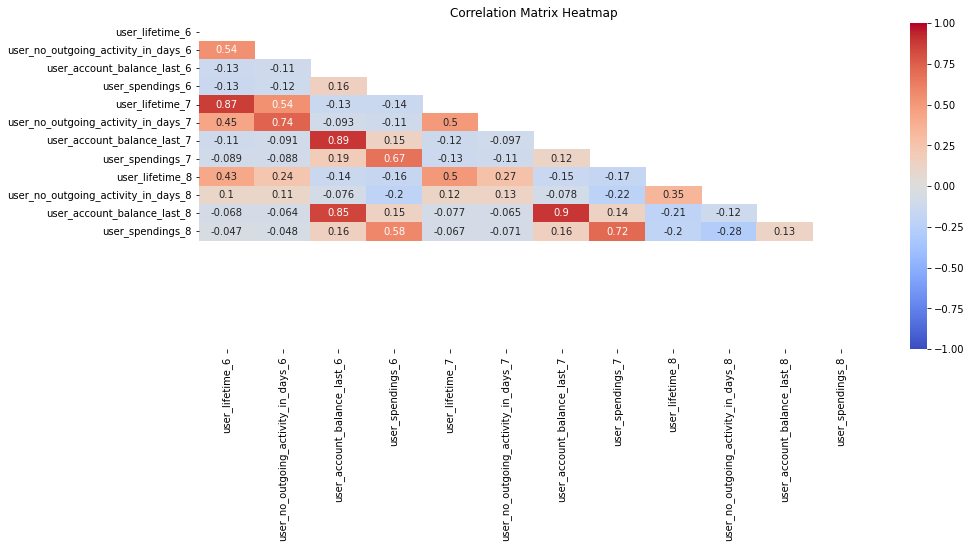

In [ ]:
mask = np.triu(user_df.corr())
plt.figure(figsize=(15,6))
sns.heatmap(user_df.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
plt.ylim(18, 0)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
user_df=user_df.drop(['user_no_outgoing_activity_in_days_6','user_lifetime_7','user_no_outgoing_activity_in_days_7','user_account_balance_last_6','user_account_balance_last_7',
                      'user_spendings_8','user_spendings_7'],axis=1)

### correlations for features in reloads df

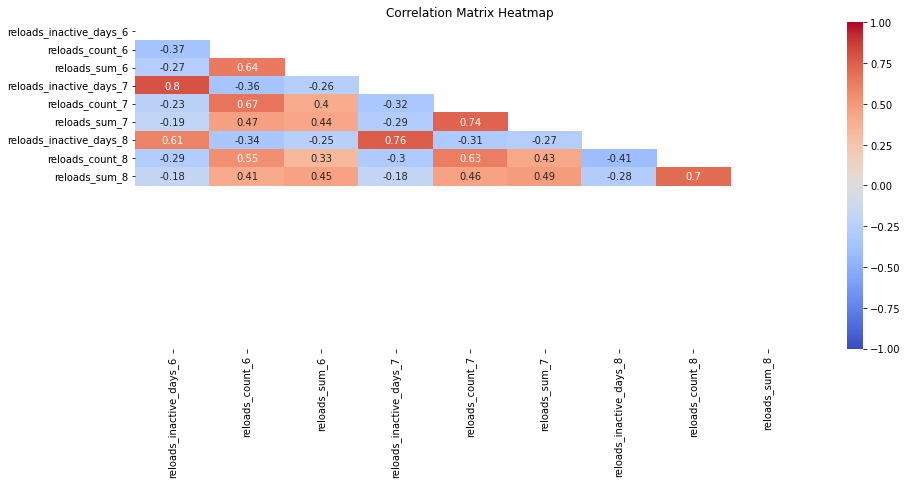

In [ ]:
mask = np.triu(reloads_df.corr())
plt.figure(figsize=(15,6))
sns.heatmap(reloads_df.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
plt.ylim(18, 0)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
reloads_df=reloads_df.drop(['reloads_inactive_days_6','reloads_inactive_days_7','reloads_count_7','reloads_sum_7','reloads_sum_8','reloads_count_8'],axis=1)

### correlations for features in calls_df

Correlation Heat Map



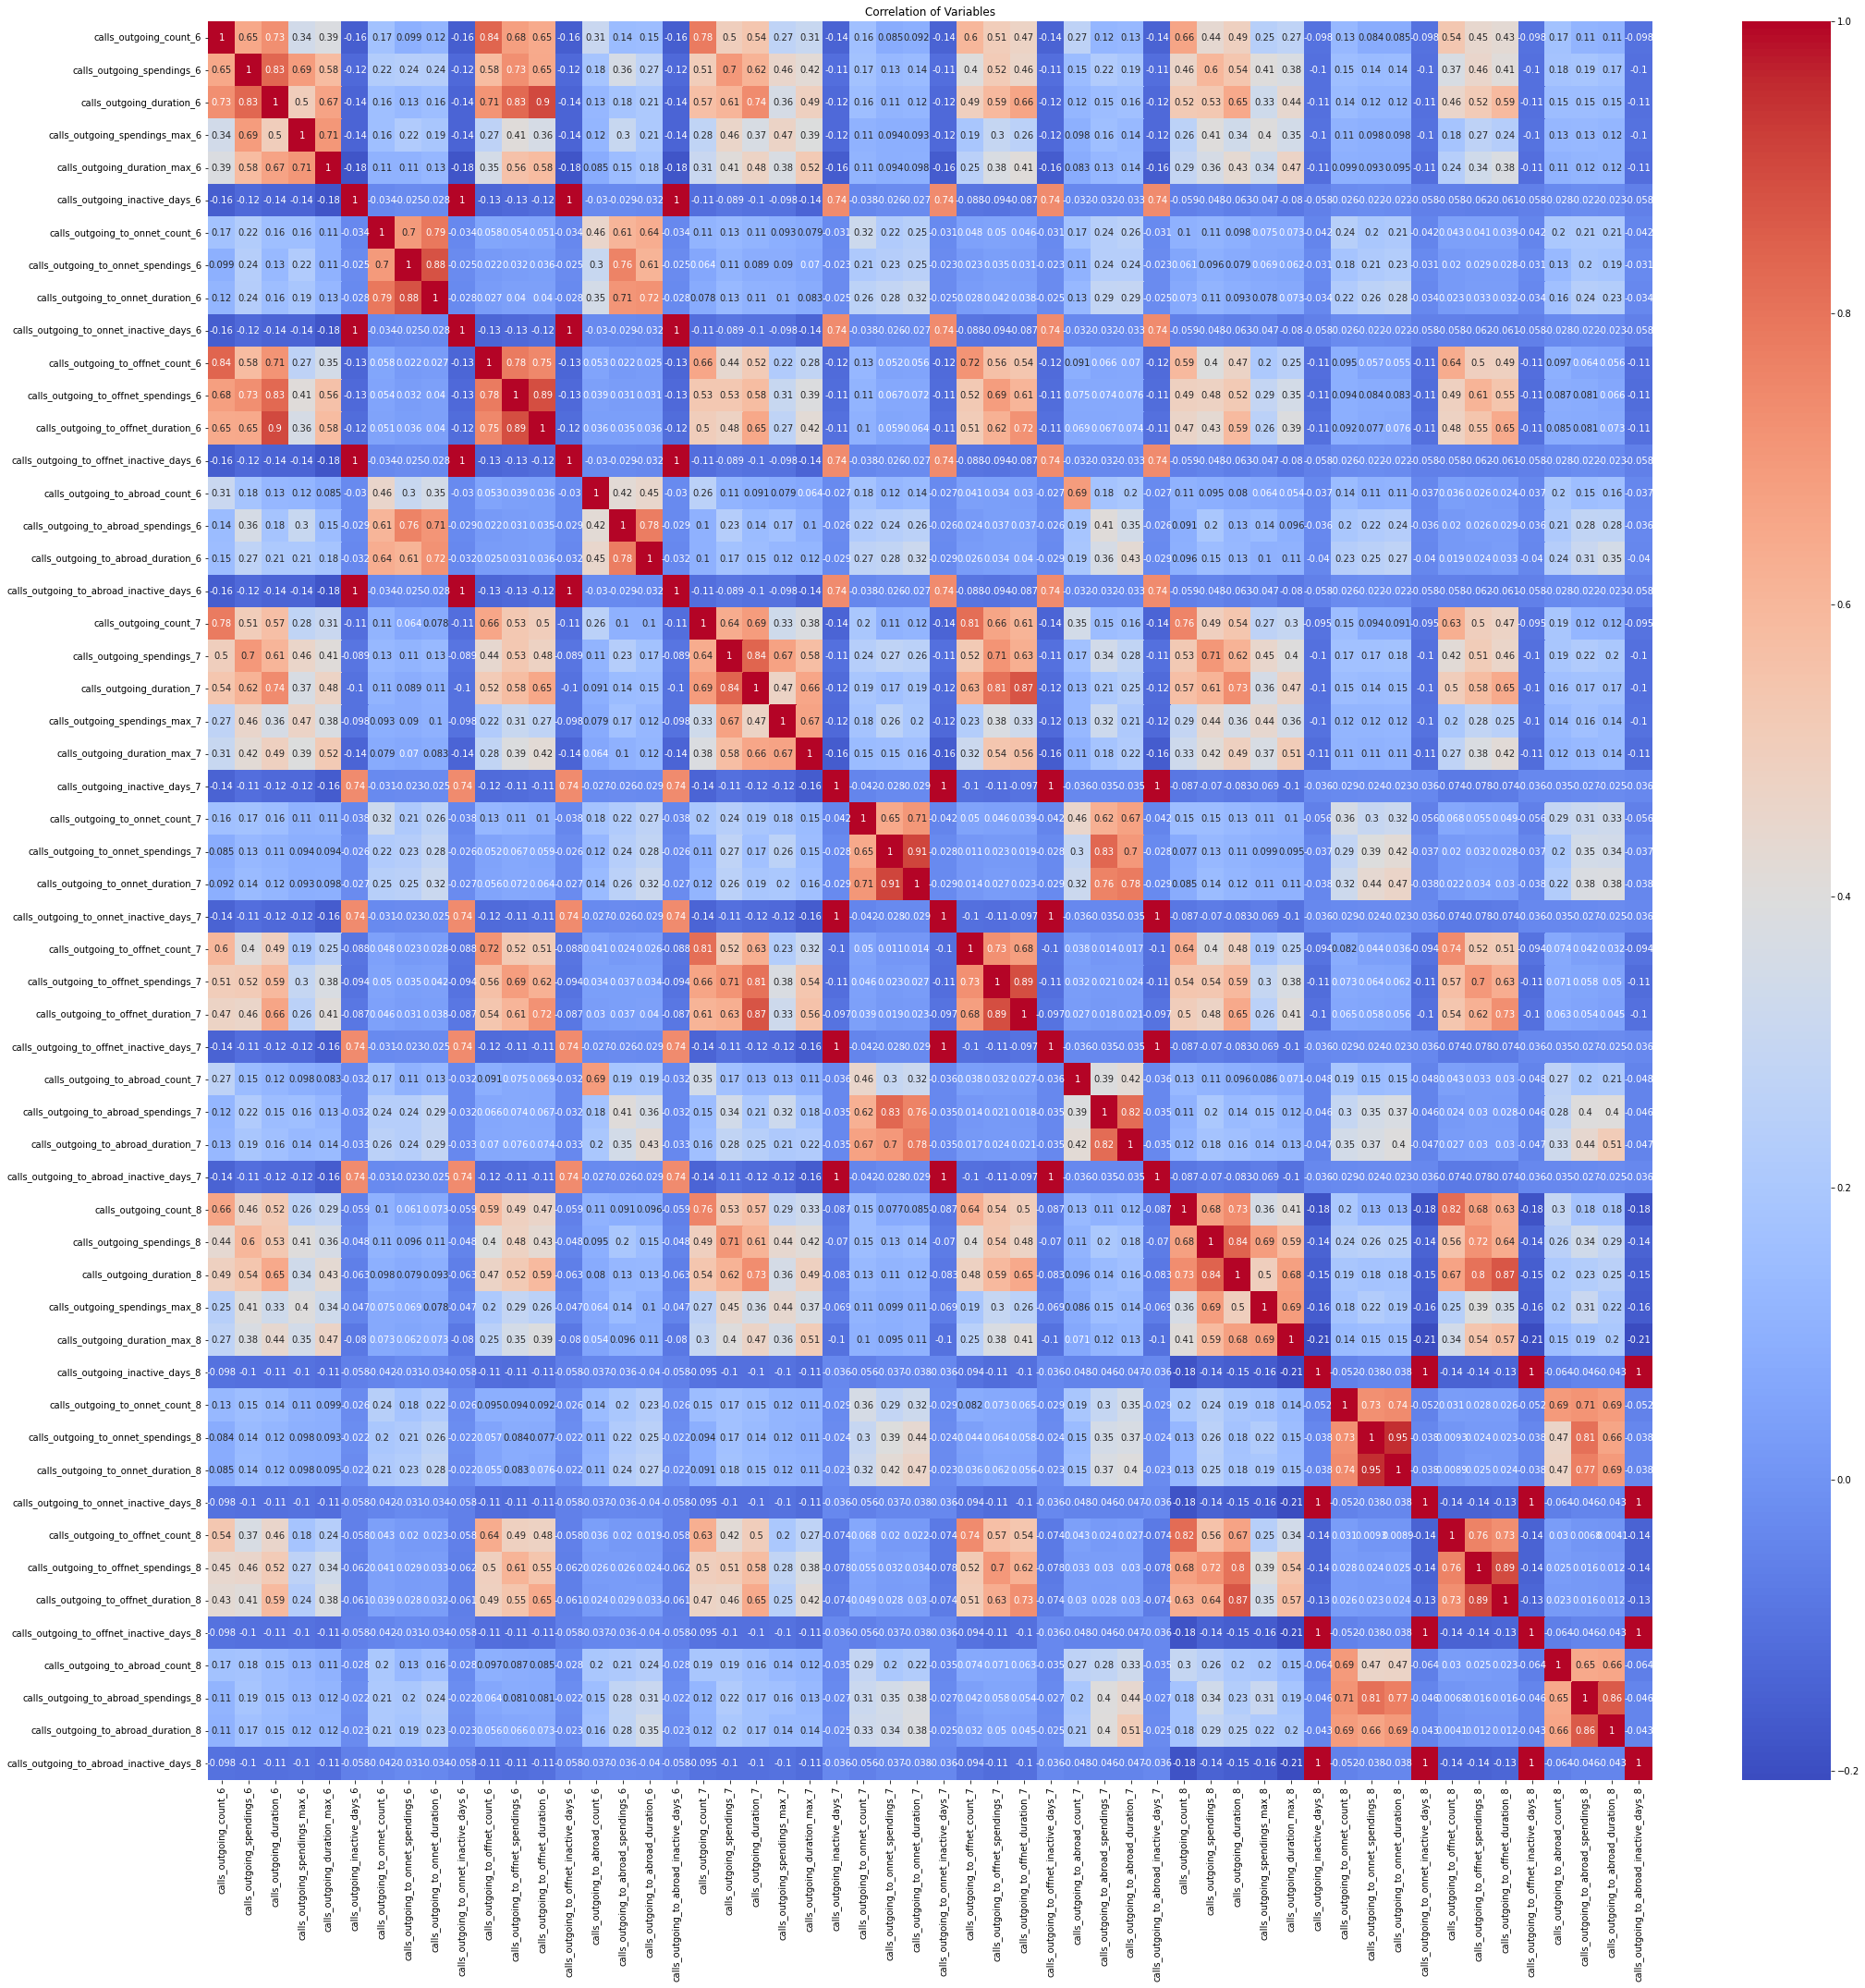

In [ ]:
import seaborn as sns
feature_names = list(calls_df.columns[0:len(calls_df.columns)])
print('Correlation Heat Map')
print()
plt.figure(figsize = (35,35))
sns.heatmap(pd.DataFrame(calls_df, columns=feature_names).corr(), annot=True,cmap='coolwarm')
plt.title('Correlation of Variables')
plt.show()

In [ ]:
calls_df=calls_df.drop(['calls_outgoing_spendings_6','calls_outgoing_duration_6','calls_outgoing_spendings_max_6','calls_outgoing_to_offnet_count_6',
       'calls_outgoing_to_offnet_spendings_6','calls_outgoing_to_offnet_duration_6','calls_outgoing_spendings_7', 'calls_outgoing_duration_7','calls_outgoing_duration_7',
       'calls_outgoing_to_onnet_spendings_6',
       'calls_outgoing_to_onnet_duration_6','calls_outgoing_to_onnet_inactive_days_6','calls_outgoing_inactive_days_6',
       'calls_outgoing_to_abroad_inactive_days_6','calls_outgoing_to_abroad_spendings_6',
       'calls_outgoing_duration_max_7','calls_outgoing_to_abroad_inactive_days_7','calls_outgoing_to_offnet_inactive_days_7','calls_outgoing_to_onnet_spendings_7',
       'calls_outgoing_to_onnet_duration_7','calls_outgoing_to_offnet_spendings_7',
       'calls_outgoing_to_offnet_duration_7','calls_outgoing_to_onnet_count_6','calls_outgoing_inactive_days_7','calls_outgoing_to_abroad_duration_7',
       'calls_outgoing_to_offnet_count_7','calls_outgoing_spendings_8', 'calls_outgoing_duration_8','calls_outgoing_spendings_max_8',
       'calls_outgoing_to_onnet_inactive_days_8','calls_outgoing_to_abroad_inactive_days_8','calls_outgoing_count_8',
      'calls_outgoing_to_onnet_spendings_8','calls_outgoing_to_onnet_duration_8','calls_outgoing_to_offnet_spendings_8',
       'calls_outgoing_to_offnet_duration_8','calls_outgoing_to_abroad_spendings_8',
       'calls_outgoing_to_abroad_duration_8','calls_outgoing_inactive_days_8'],axis=1)

### correlations for features in sms_df

Correlation Heat Map



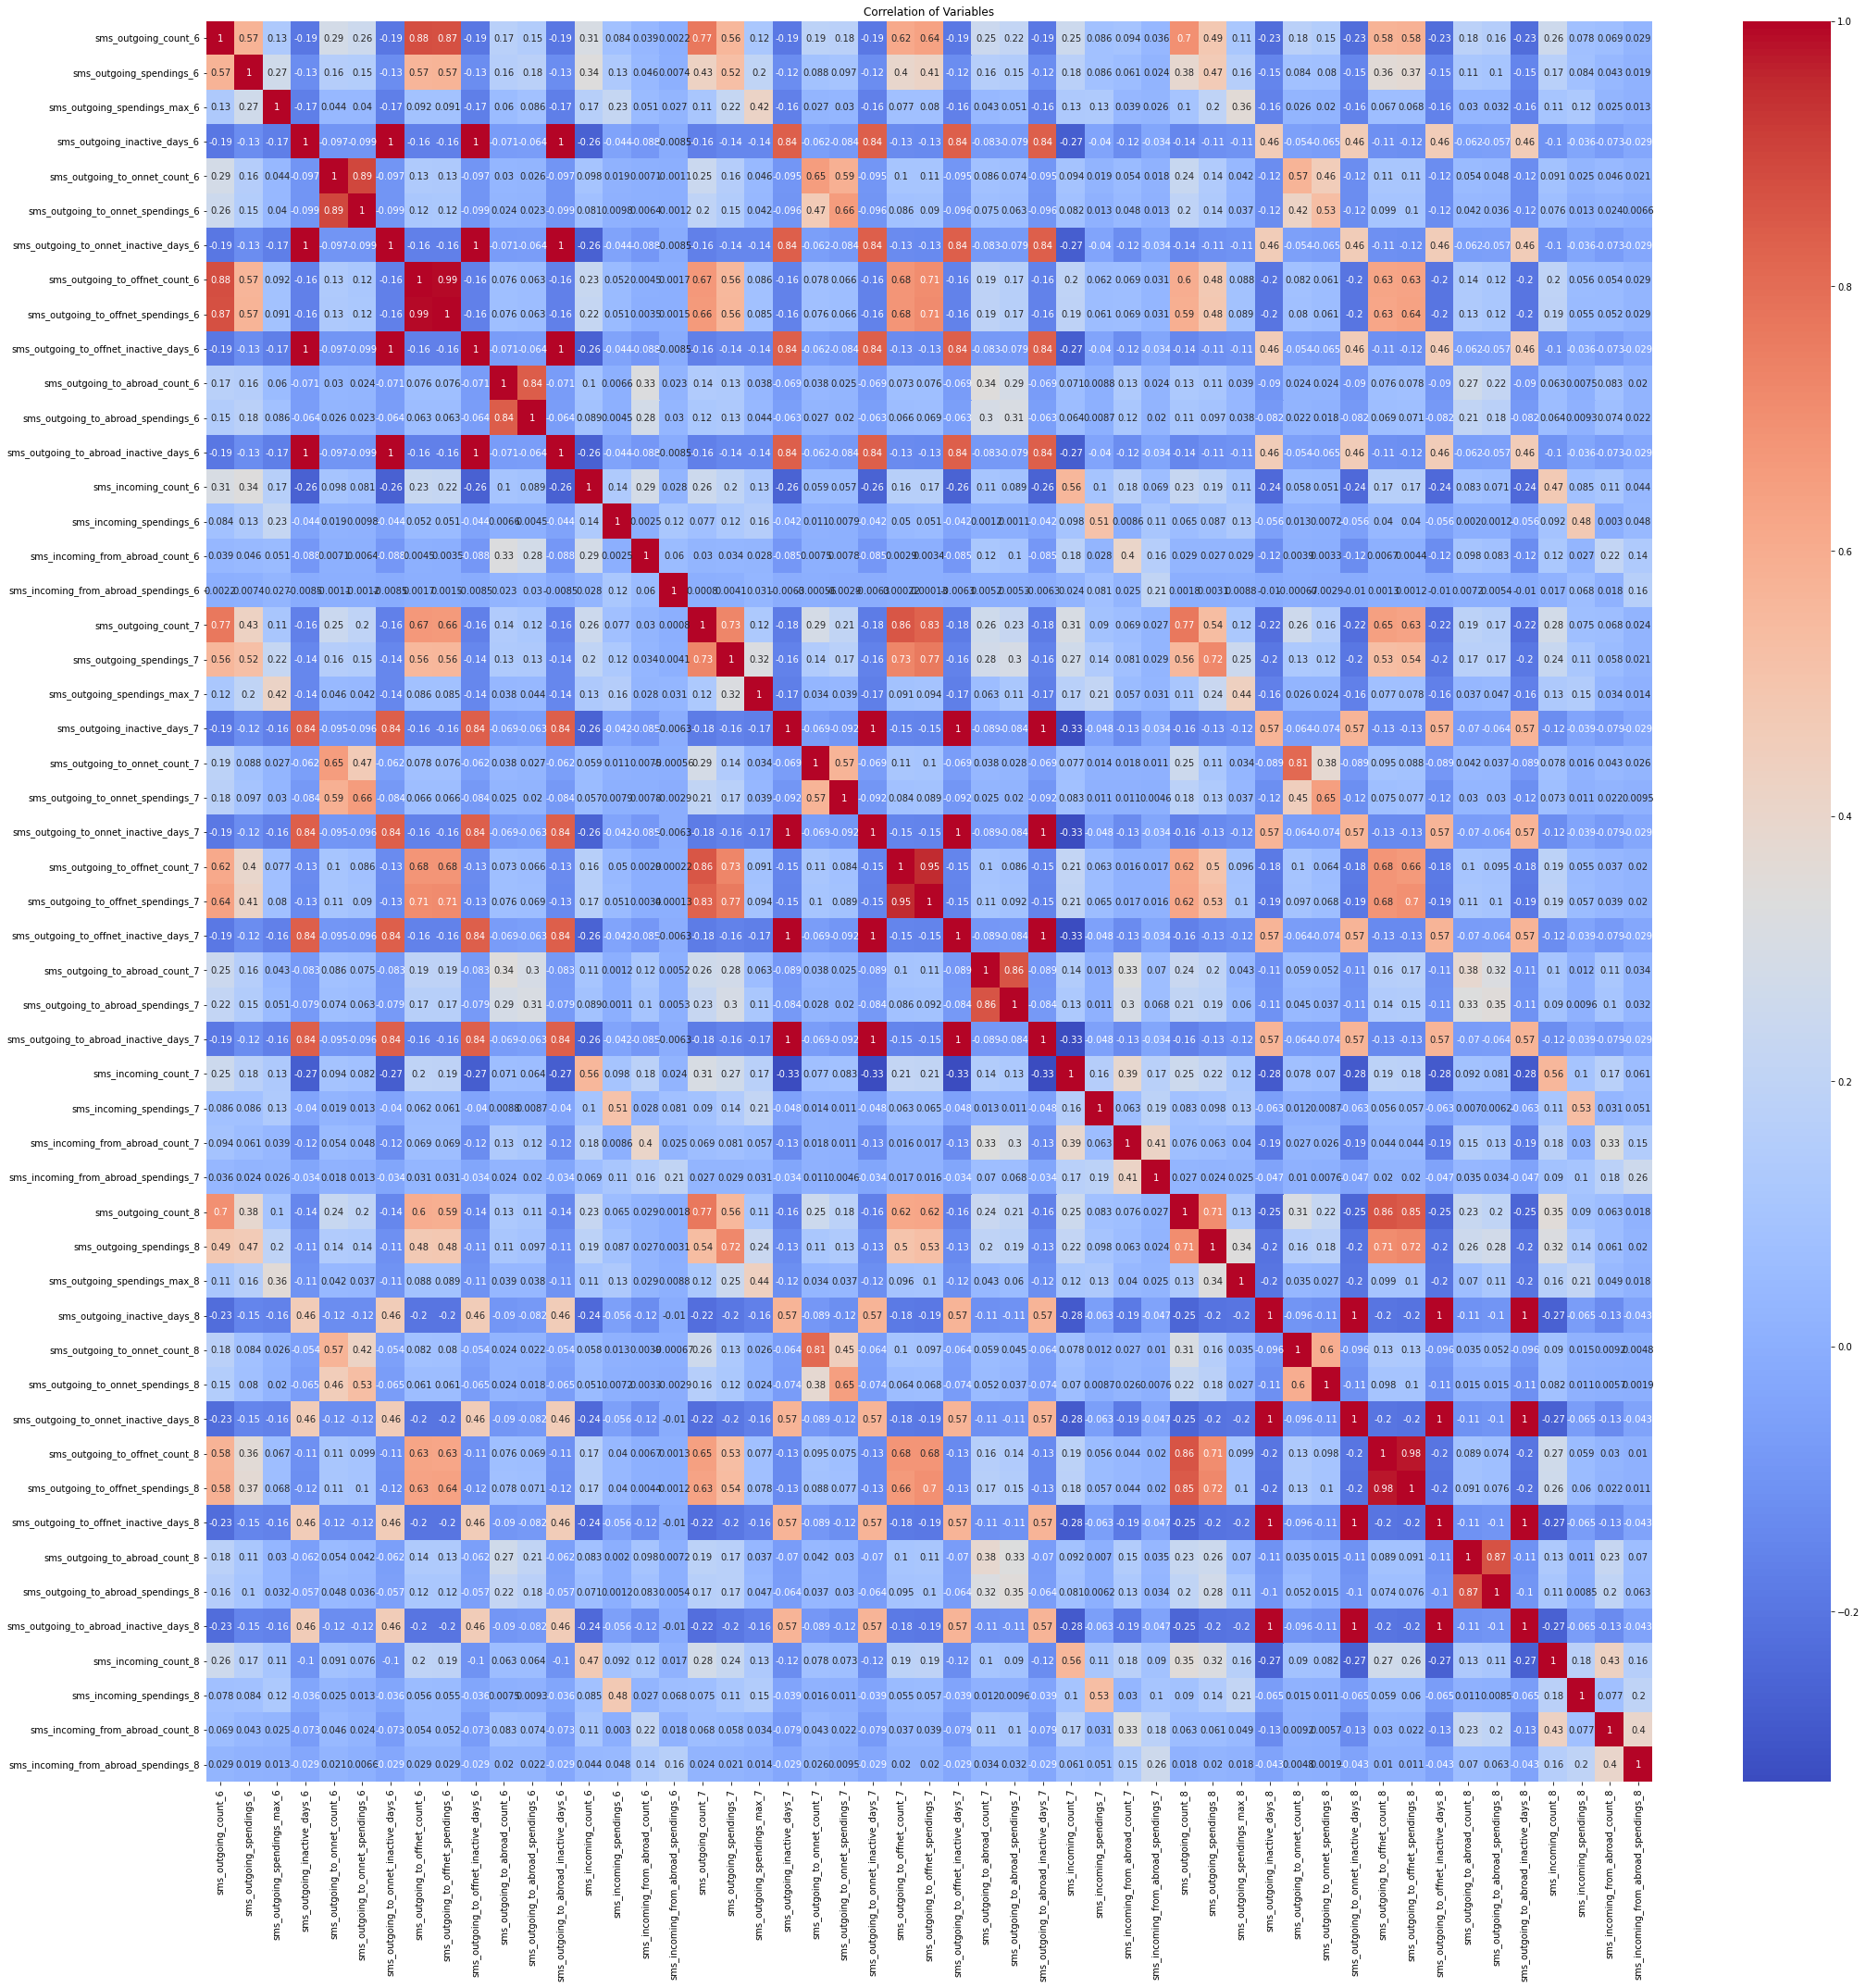

In [ ]:
import seaborn as sns
feature_names = list(sms_df.columns[0:len(sms_df.columns)])
print('Correlation Heat Map')
print()
plt.figure(figsize = (35,35))
sns.heatmap(pd.DataFrame(sms_df, columns=feature_names).corr(), annot=True,cmap='coolwarm')
plt.title('Correlation of Variables')
plt.show()

In [ ]:
sms_df= sms_df.drop(['sms_outgoing_inactive_days_6','sms_outgoing_to_onnet_spendings_6','sms_outgoing_to_offnet_count_6','sms_outgoing_to_abroad_count_6', 'sms_outgoing_spendings_max_6','sms_outgoing_to_onnet_inactive_days_6', 'sms_outgoing_to_offnet_inactive_days_6','sms_outgoing_to_abroad_inactive_days_6','sms_outgoing_count_7','sms_outgoing_to_offnet_count_7','sms_outgoing_to_abroad_spendings_7', 'sms_outgoing_inactive_days_7','sms_outgoing_to_onnet_count_7', 'sms_outgoing_to_onnet_inactive_days_7','sms_outgoing_to_offnet_inactive_days_7','sms_outgoing_count_8', 'sms_outgoing_to_offnet_spendings_6', 'sms_outgoing_to_offnet_spendings_8', 'sms_outgoing_to_abroad_count_8', 'sms_outgoing_to_onnet_spendings_8', 'sms_outgoing_inactive_days_8', 'sms_outgoing_to_onnet_inactive_days_8','sms_outgoing_to_offnet_inactive_days_8', 'sms_outgoing_to_abroad_inactive_days_8', 'sms_outgoing_spendings_7', 'sms_outgoing_to_offnet_spendings_7', 'sms_outgoing_spendings_8', 'sms_outgoing_to_offnet_count_8'], axis=1)

### correlations for features in gprs_df

Correlation Heat Map



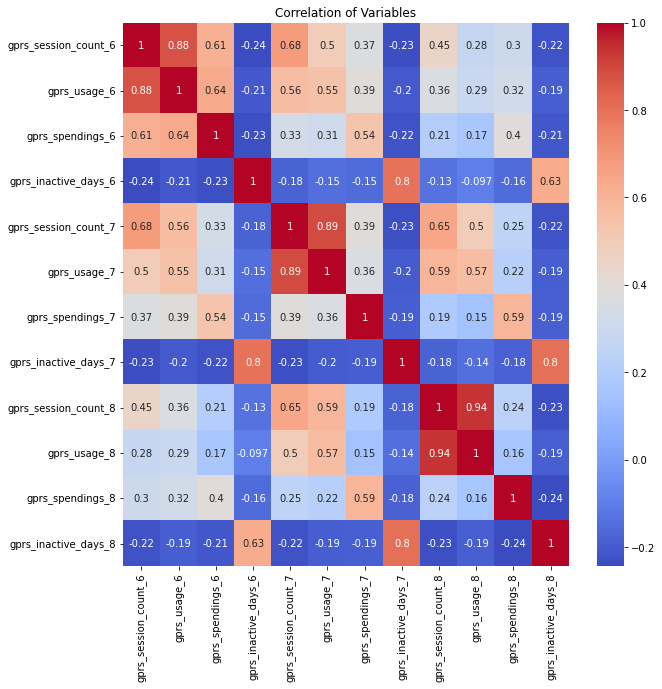

In [ ]:
import seaborn as sns
feature_names = list(gprs_df.columns[0:len(gprs_df.columns)])
print('Correlation Heat Map')
print()
plt.figure(figsize = (10,10))
sns.heatmap(pd.DataFrame(gprs_df, columns=feature_names).corr(), annot=True,cmap='coolwarm')
plt.title('Correlation of Variables')
plt.show()

In [ ]:
gprs_df=gprs_df.drop(['gprs_session_count_7','gprs_usage_8','gprs_inactive_days_7','gprs_inactive_days_6','gprs_session_count_8','gprs_usage_6'],axis=1)

### correlations for features in last_100_df

Correlation Heat Map



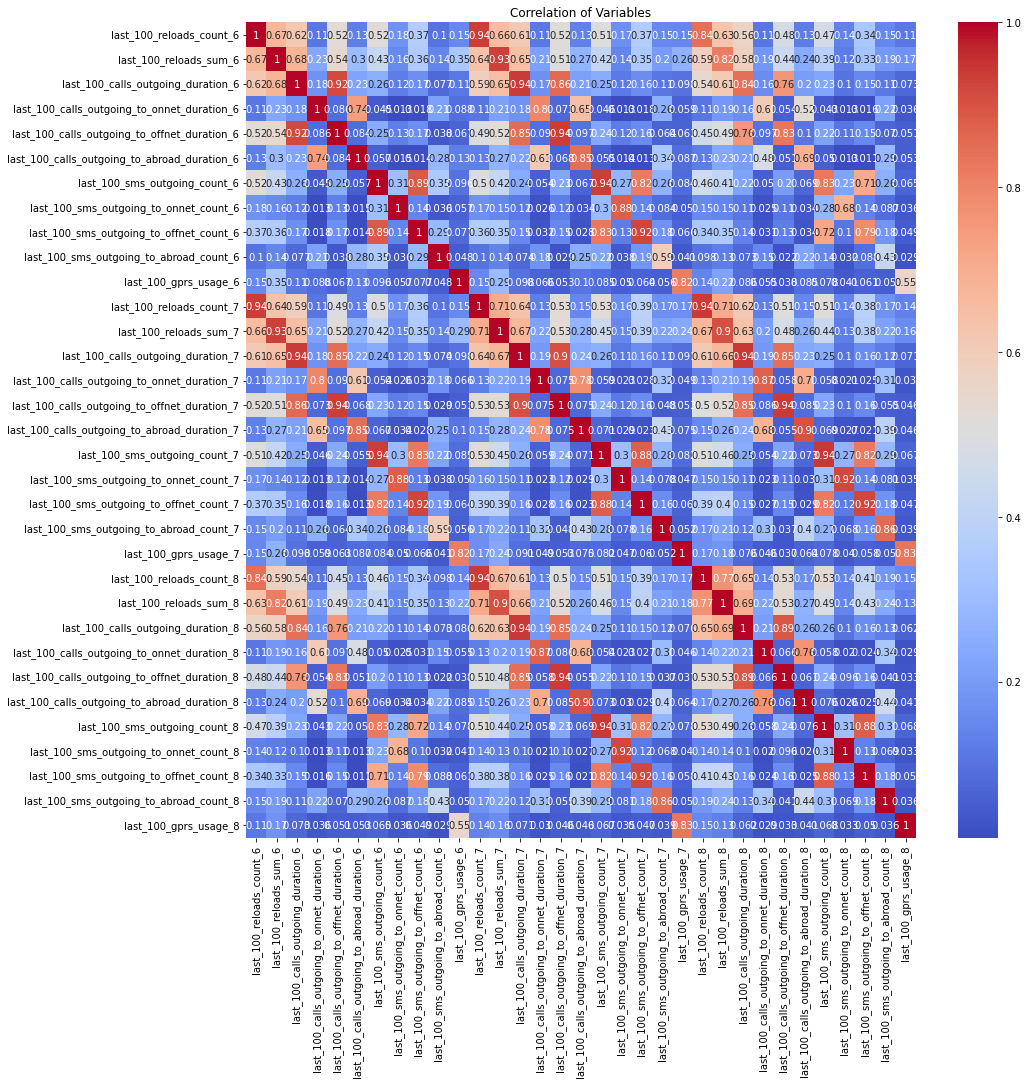

In [ ]:
import seaborn as sns
feature_names = list(last_100_df.columns[0:len(last_100_df.columns)])
print('Correlation Heat Map')
print()
plt.figure(figsize = (15,15))
sns.heatmap(pd.DataFrame(last_100_df, columns=feature_names).corr(), annot=True,cmap='coolwarm')
plt.title('Correlation of Variables')
plt.show()

In [ ]:
last_100_df=last_100_df.drop(['last_100_sms_outgoing_to_abroad_count_7','last_100_calls_outgoing_duration_7','last_100_sms_outgoing_count_8',
                              'last_100_gprs_usage_7','last_100_calls_outgoing_to_abroad_duration_8',
                              'last_100_sms_outgoing_to_offnet_count_7','last_100_sms_outgoing_to_abroad_count_8','last_100_gprs_usage_8',
                              'last_100_calls_outgoing_to_onnet_duration_8','last_100_calls_outgoing_to_onnet_duration_7',
                              'last_100_sms_outgoing_count_7','last_100_sms_outgoing_to_onnet_count_7','last_100_sms_outgoing_count_6',
                              'last_100_calls_outgoing_duration_6','last_100_calls_outgoing_to_offnet_duration_7','last_100_reloads_sum_8',
                              'last_100_calls_outgoing_duration_8','last_100_reloads_sum_6','last_100_reloads_count_6','last_100_calls_outgoing_to_offnet_duration_6','last_100_calls_outgoing_to_abroad_duration_6',
                              'last_100_sms_outgoing_to_offnet_count_6','last_100_reloads_count_7', 'last_100_reloads_sum_7'],axis=1)

### Combining all the columns from all the dataframes created above.

In [ ]:
col=user_df.columns.append([reloads_df.columns,calls_df.columns,gprs_df.columns,sms_df.columns,last_100_df.columns])

In [ ]:
len(col)

62

### Creating a data frame containing continuous features after removing the correlated continuous features.

In [ ]:
df_new=df_new[col]

### Correlations for final data set

Correlation Heat Map



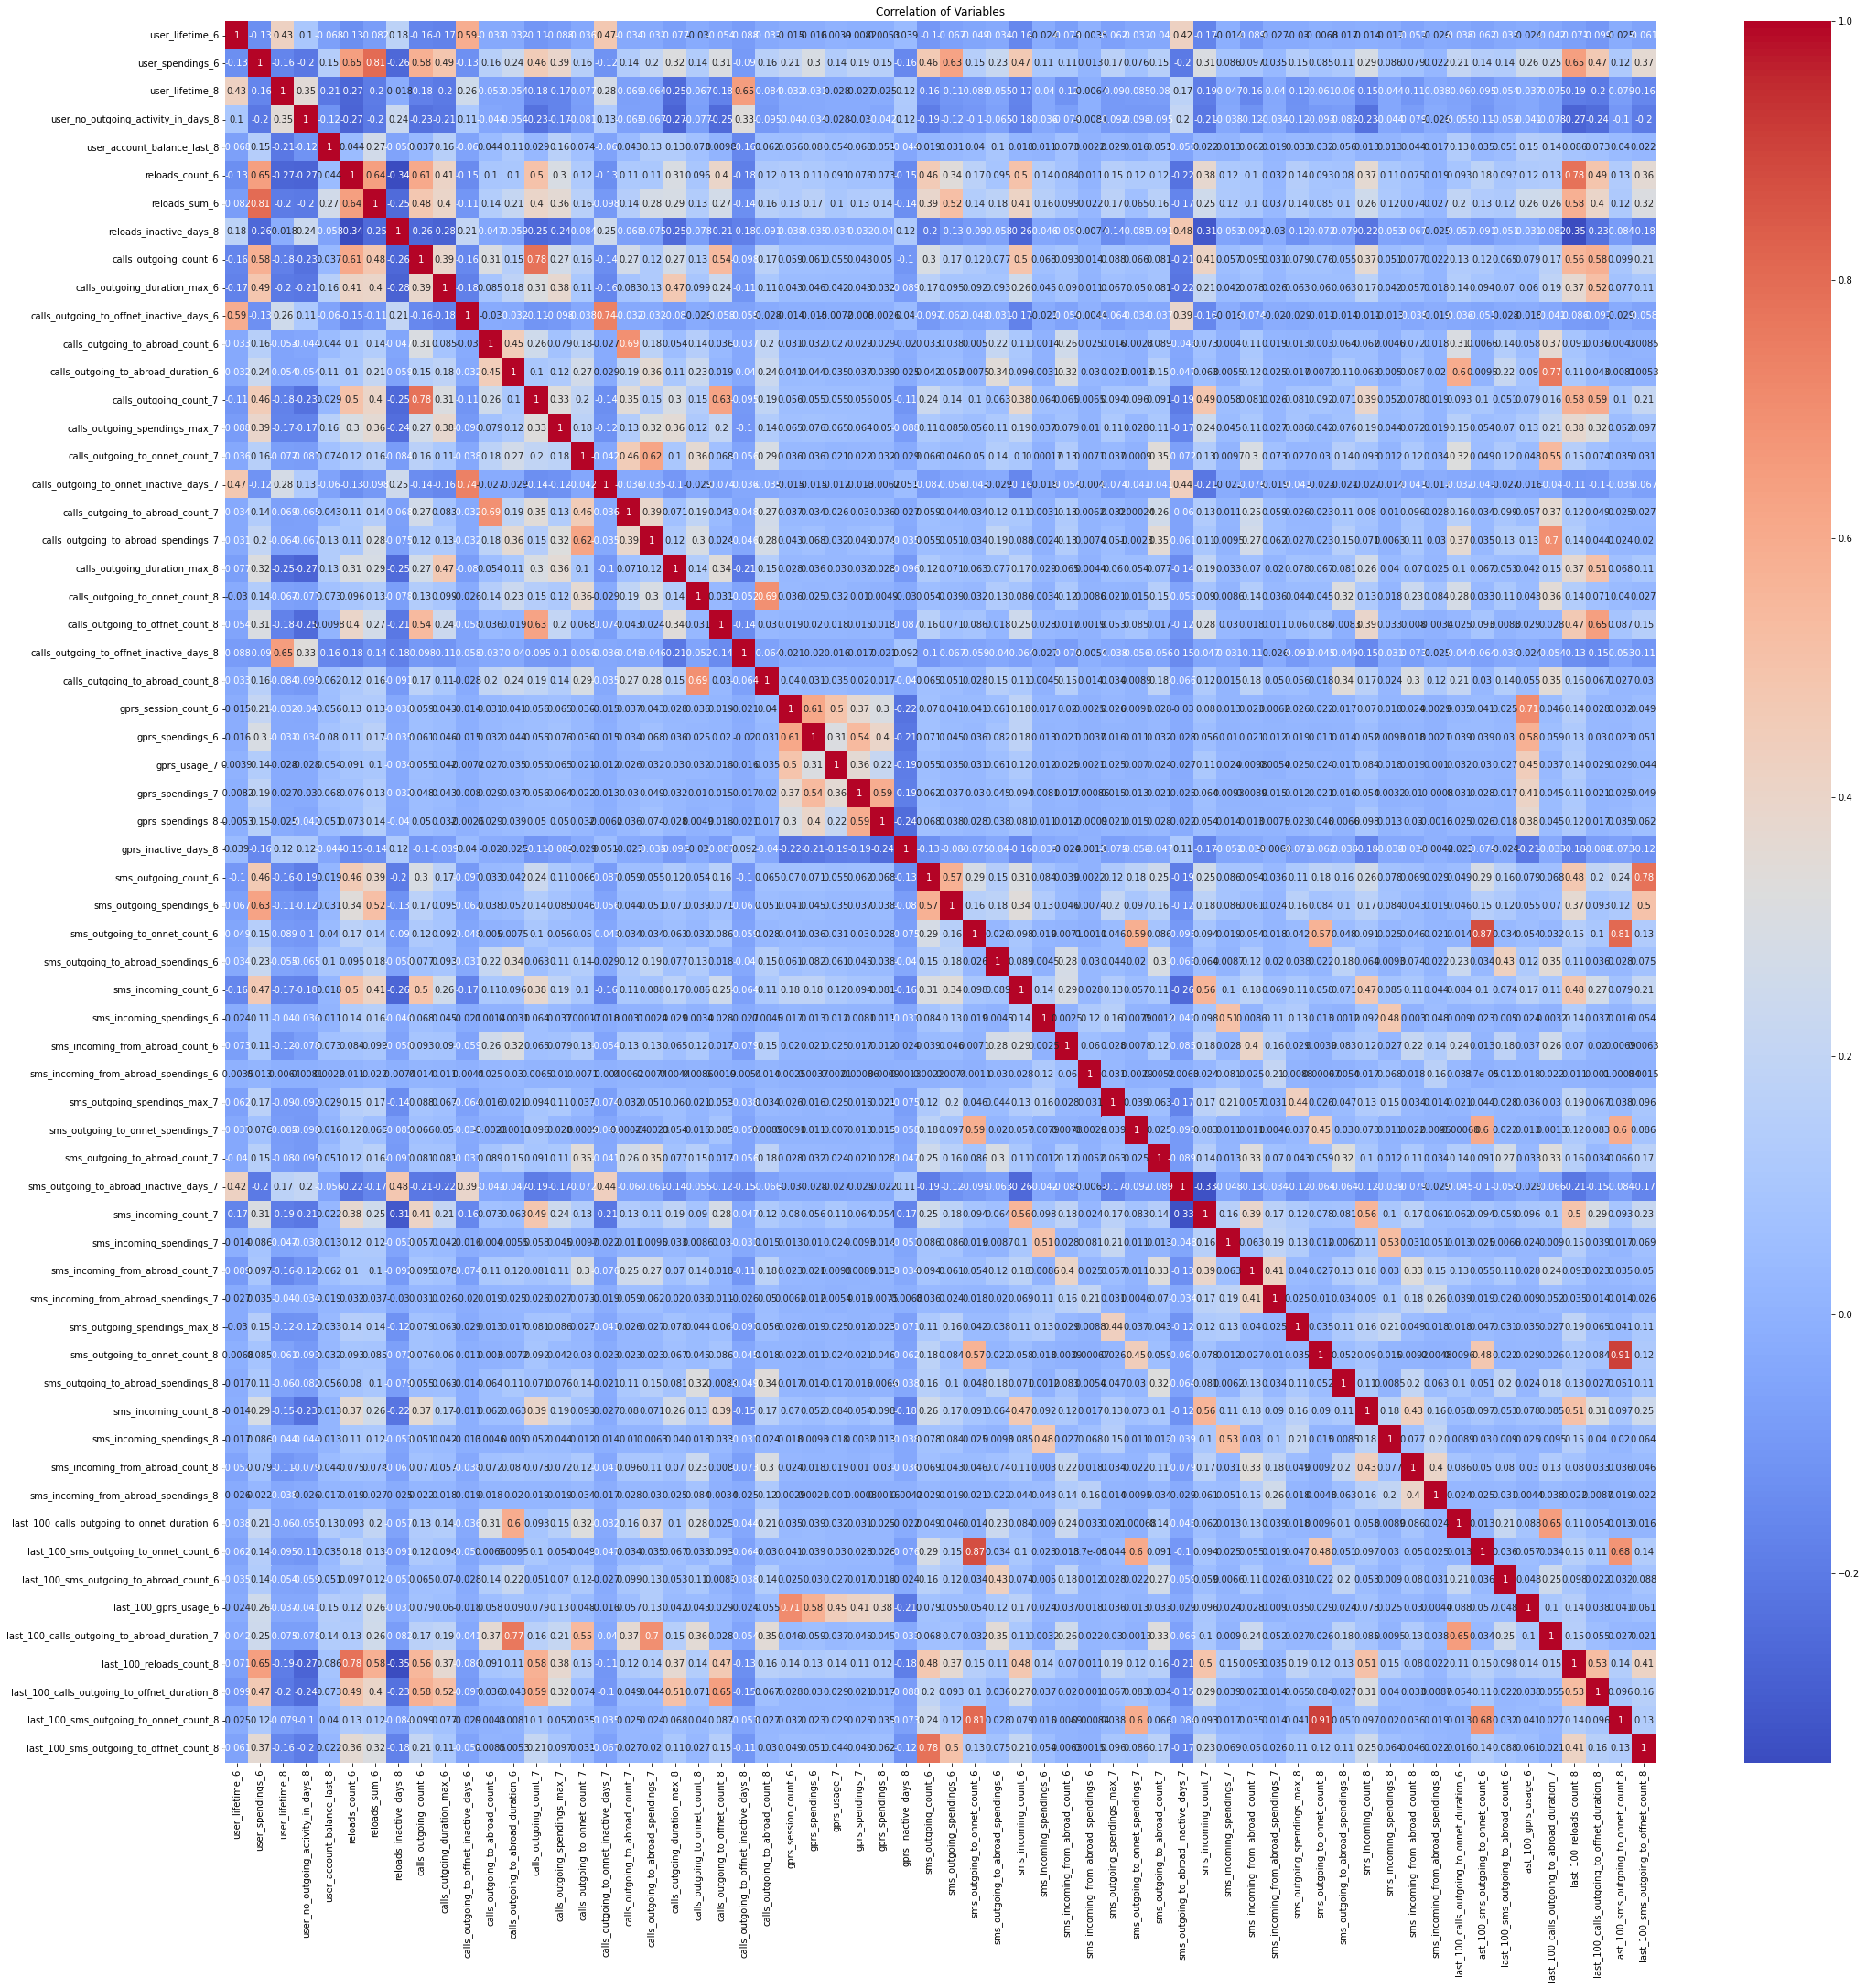

In [ ]:
import seaborn as sns
feature_names = list(df_new.columns[0:len(df_new.columns)])
print('Correlation Heat Map')
print()
plt.figure(figsize = (35,35))
sns.heatmap(pd.DataFrame(df_new, columns=feature_names).corr(), annot=True,cmap='coolwarm')
plt.title('Correlation of Variables')
plt.show()

In [ ]:
df_new=df_new.drop(['sms_outgoing_count_6','sms_outgoing_to_onnet_count_6','sms_outgoing_to_onnet_count_8','calls_outgoing_count_6','reloads_sum_6',
                    'calls_outgoing_to_abroad_duration_6','last_100_reloads_count_8'],axis=1)

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66469 entries, 13 to 1196944
Data columns (total 55 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   user_lifetime_6                               66469 non-null  float64
 1   user_spendings_6                              66469 non-null  float64
 2   user_lifetime_8                               66469 non-null  int64  
 3   user_no_outgoing_activity_in_days_8           66469 non-null  int64  
 4   user_account_balance_last_8                   66469 non-null  float64
 5   reloads_count_6                               66469 non-null  float64
 6   reloads_inactive_days_8                       66469 non-null  int64  
 7   calls_outgoing_duration_max_6                 66469 non-null  float64
 8   calls_outgoing_to_offnet_inactive_days_6      66469 non-null  float64
 9   calls_outgoing_to_abroad_count_6              66469 non-nu

* We have 55 continuous variables after removing all the correlated variables.

### Checking the value counts of all the  categorical variables.

In [ ]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66469 entries, 13 to 1196944
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   user_intake_6              57656 non-null  object
 1   user_has_outgoing_calls_6  57656 non-null  object
 2   user_has_outgoing_sms_6    57656 non-null  object
 3   user_use_gprs_6            57656 non-null  object
 4   user_does_reload_6         57656 non-null  object
 5   user_intake_7              58218 non-null  object
 6   user_has_outgoing_calls_7  58218 non-null  object
 7   user_has_outgoing_sms_7    58218 non-null  object
 8   user_use_gprs_7            58218 non-null  object
 9   user_does_reload_7         58218 non-null  object
 10  user_intake_8              66469 non-null  object
 11  user_has_outgoing_calls_8  66469 non-null  object
 12  user_has_outgoing_sms_8    66469 non-null  object
 13  user_use_gprs_8            66469 non-null  object
 14  use

In [ ]:
for i in df_cat.columns:
  print(df_cat[i].value_counts())

0    56506
1     1150
Name: user_intake_6, dtype: int64
1    50518
0     7138
Name: user_has_outgoing_calls_6, dtype: int64
1    38837
0    18819
Name: user_has_outgoing_sms_6, dtype: int64
0    54932
1     2724
Name: user_use_gprs_6, dtype: int64
0    29198
1    28458
Name: user_does_reload_6, dtype: int64
0    56869
1     1349
Name: user_intake_7, dtype: int64
1    51023
0     7195
Name: user_has_outgoing_calls_7, dtype: int64
1    39436
0    18782
Name: user_has_outgoing_sms_7, dtype: int64
0    55163
1     3055
Name: user_use_gprs_7, dtype: int64
0    32591
1    25627
Name: user_does_reload_7, dtype: int64
0    64335
1     2134
Name: user_intake_8, dtype: int64
1    59638
0     6831
Name: user_has_outgoing_calls_8, dtype: int64
1    41628
0    24841
Name: user_has_outgoing_sms_8, dtype: int64
0    63060
1     3409
Name: user_use_gprs_8, dtype: int64
1    35561
0    30908
Name: user_does_reload_8, dtype: int64


### Imputing the null values in the categorical features with their highest frequent value. 

In [ ]:
df_cat['user_intake_6'] = df_cat['user_intake_6'].fillna(0)
df_cat['user_has_outgoing_calls_6'] = df_cat['user_has_outgoing_calls_6'].fillna(1)
df_cat['user_has_outgoing_sms_6'] = df_cat['user_has_outgoing_sms_6'].fillna(1)
df_cat['user_use_gprs_6'] = df_cat['user_use_gprs_6'].fillna(0)
df_cat['user_does_reload_6'] = df_cat['user_does_reload_6'].fillna(0)
df_cat['user_intake_7'] = df_cat['user_intake_7'].fillna(0)
df_cat['user_has_outgoing_calls_7'] = df_cat['user_has_outgoing_calls_7'].fillna(1)
df_cat['user_has_outgoing_sms_7'] = df_cat['user_has_outgoing_sms_7'].fillna(1)
df_cat['user_use_gprs_7'] = df_cat['user_use_gprs_7'].fillna(0)
df_cat['user_does_reload_7'] = df_cat['user_does_reload_7'].fillna(0)

### Converting the datatype of all categorical variables from 

In [ ]:
df_cat['user_intake_6'] = df_cat['user_intake_6'].astype(object)
df_cat['user_has_outgoing_calls_6'] = df_cat['user_has_outgoing_calls_6'].astype(object)
df_cat['user_has_outgoing_sms_6'] = df_cat['user_has_outgoing_sms_6'].astype(object)
df_cat['user_use_gprs_6'] = df_cat['user_use_gprs_6'].astype(object)
df_cat['user_does_reload_6'] = df_cat['user_does_reload_6'].astype(object)
df_cat['user_intake_7'] = df_cat['user_intake_7'].astype(object)
df_cat['user_has_outgoing_calls_7'] = df_cat['user_has_outgoing_calls_7'].astype(object)
df_cat['user_has_outgoing_sms_7'] = df_cat['user_has_outgoing_sms_7'].astype(object)
df_cat['user_use_gprs_7'] = df_cat['user_use_gprs_7'].astype(object)
df_cat['user_does_reload_7'] = df_cat['user_does_reload_7'].astype(object)

### Checking the data type of all categorical variables

In [ ]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66469 entries, 13 to 1196944
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   user_intake_6              66469 non-null  object
 1   user_has_outgoing_calls_6  66469 non-null  object
 2   user_has_outgoing_sms_6    66469 non-null  object
 3   user_use_gprs_6            66469 non-null  object
 4   user_does_reload_6         66469 non-null  object
 5   user_intake_7              66469 non-null  object
 6   user_has_outgoing_calls_7  66469 non-null  object
 7   user_has_outgoing_sms_7    66469 non-null  object
 8   user_use_gprs_7            66469 non-null  object
 9   user_does_reload_7         66469 non-null  object
 10  user_intake_8              66469 non-null  object
 11  user_has_outgoing_calls_8  66469 non-null  object
 12  user_has_outgoing_sms_8    66469 non-null  object
 13  user_use_gprs_8            66469 non-null  object
 14  use

### Concatinating the data frames containing categorical and continuous variables individualy.

In [ ]:
df_final = pd.concat([df_new,df_cat], axis=1, join='inner')

In [ ]:
df_final.shape

(66469, 70)

### Concatinating the above dataframe containig the independent variables with the target column.

In [ ]:
df_final = pd.concat([df_final,df2], axis=1, join='inner')
display(df_final)

user_lifetime_6  user_spendings_6  user_lifetime_8  \
13                1000.0              0.00             1062   
14                1000.0              3.45             1062   
18                1005.0              1.97             1067   
27                1013.0              0.00             1075   
32                1032.0              0.15             1094   
...                  ...               ...              ...   
1196937           1021.0              3.23            15947   
1196938           1021.0              3.23            15947   
1196939           1021.0              3.23            15947   
1196940           1021.0              3.23            15947   
1196944           1021.0              3.23                1   

         user_no_outgoing_activity_in_days_8  user_account_balance_last_8  \
13                                         1                         0.96   
14                                         1                        27.38   
18                                         1                        11.41   
27                                        10                         3.69   
32                                         1                         2.80   
...                                      ...                          ...   
1196937                                    1                         0.00   
1196938                                    1                         0.00   
1196939                                    1                        15.00   
1196940                                    1                         0.00   
1196944                                    1                        15.00   

         reloads_count_6  reloads_inactive_days_8  \
13                   0.0                       60   
14                   0.0                     1338   
18                   0.0                     1338   
27                   0.0                     1338   
32                   1.0                       79   
...                  ...                      ...   
1196937              0.0                        1   
1196938              0.0                        1   
1196939              0.0                        1   
1196940              0.0                        1   
1196944              0.0                        1   

         calls_outgoing_duration_max_6  \
13                                0.58   
14                                4.33   
18                                9.23   
27                                0.00   
32                                1.00   
...                                ...   
1196937                           2.62   
1196938                           2.62   
1196939                           2.62   
1196940                           2.62   
1196944                           2.62   

         calls_outgoing_to_offnet_inactive_days_6  \
13                                            1.0   
14                                           25.0   
18                                            8.0   
27                                           11.0   
32                                            2.0   
...                                           ...   
1196937                                       3.0   
1196938                                       3.0   
1196939                                       3.0   
1196940                                       3.0   
1196944                                       3.0   

         calls_outgoing_to_abroad_count_6  calls_outgoing_count_7  \
13                                    0.0                    68.0   
14                                    5.0                     5.0   
18                                    6.0                    13.0   
27                                    0.0                     0.0   
32                                    0.0                    33.0   
...                                   ...                     ...   
1196937                               0.0                    18.0

## VIF

In [ ]:
feat_names=df_new.columns[:]

VIF =[variance_inflation_factor(np.array(df_new), i) for i in range(np.array(df_new).shape[1])]
for idx, vif in enumerate(VIF):
    print('{0}: {1}'.format(feat_names[idx], vif))
    
# Printing Total Cases of Possible or Definite Multicollinearity

problem_multicollinearity = sum([1 for vif in VIF if vif > 5])
certain_multicollinearity = sum([1 for vif in VIF if vif > 10])
print()
print('{0} cases of Problematic Multicollinearity'.format(problem_multicollinearity))
print('{0} cases of Certain Multicollinearity'.format(certain_multicollinearity))
print()

user_lifetime_6: 2.97330408667557
user_spendings_6: 6.072381537115829
user_lifetime_8: 4.5283230850888
user_no_outgoing_activity_in_days_8: 2.6504562177019553
user_account_balance_last_8: 1.4407570676002237
reloads_count_6: 3.2481791539969067
reloads_inactive_days_8: 2.2336883212698733
calls_outgoing_duration_max_6: 2.778355831049437
calls_outgoing_to_offnet_inactive_days_6: 2.8907283721690304
calls_outgoing_to_abroad_count_6: 2.6938424631070297
calls_outgoing_count_7: 3.9604391940592705
calls_outgoing_spendings_max_7: 1.9242078087943946
calls_outgoing_to_onnet_count_7: 2.1868571110531074
calls_outgoing_to_onnet_inactive_days_7: 2.5755459918929673
calls_outgoing_to_abroad_count_7: 3.233295104369812
calls_outgoing_to_abroad_spendings_7: 2.841974186681477
calls_outgoing_duration_max_8: 2.2763414588052258
calls_outgoing_to_onnet_count_8: 2.2103546152693325
calls_outgoing_to_offnet_count_8: 2.8711755694826997
calls_outgoing_to_offnet_inactive_days_8: 2.968235650229559
calls_outgoing_to_abr

In [ ]:
from ipywidgets import interact 

### Interactive info tables

### Boxplot for all the variables.

In [ ]:
@interact
def groupby(index=list(df_final.select_dtypes(['float64','int64']).columns)):
  return sns.boxplot(df_final[index])

interactive(children=(Dropdown(description='index', options=('user_lifetime_6', 'user_spendings_6', 'user_life…

### Distribution plot for all the variables.

In [ ]:
@interact
def groupby(index=list(df_final.select_dtypes(['float64','int64']).columns)):
  return sns.distplot(df_final[index])

interactive(children=(Dropdown(description='index', options=('user_lifetime_6', 'user_spendings_6', 'user_life…

### Histogram plot for all the variables.

In [ ]:
@interact
def groupby(index=list(df_final.select_dtypes(['float64','int64']).columns)):
  return sns.histplot(df_final[index])

interactive(children=(Dropdown(description='index', options=('user_lifetime_6', 'user_spendings_6', 'user_life…

### Bar plots for all categorical variables vs continous variables.

In [ ]:
@interact
def groupby(column=list(df_final.select_dtypes('object').columns),
     index=list(df_final.select_dtypes(['float64','int64']).columns)):
   return sns.barplot(x=df_final[column],y=df_final[index])

interactive(children=(Dropdown(description='column', options=('user_intake_6', 'user_has_outgoing_calls_6', 'u…

### Train Test Split with 80/20 ratio

In [ ]:
Y=df_final['churn']
X=df_final.drop(['churn'],axis=1)

In [ ]:
Y.value_counts()

0    52562
1    13907
Name: churn, dtype: int64

* We can observe that the dataset is imbalanced.

In [ ]:
Y.dtypes

dtype('int64')

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

In [ ]:
from sklearn.utils.multiclass import type_of_target
type_of_target(Y)

'binary'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.2)

In [ ]:
print("Shape of X_train:",X_train.shape)
print("Shape of X_test :", X_test.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test :",y_test.shape)

Shape of X_train: (53175, 70)
Shape of X_test : (13294, 70)
Shape of y_train: (53175,)
Shape of y_test : (13294,)


### Distribution of class in target variable for the train dataset

In [ ]:
temp=pd.DataFrame(y_train)
temp.value_counts()

0    42049
1    11126
dtype: int64

###Distribution of class in target variable for the test dataset

In [ ]:
temp=pd.DataFrame(y_test)
temp.value_counts()

0    10513
1     2781
dtype: int64

* Since we used stratify while splitting our dataset both the train and test data set have same proportion of classes in the target variable i.e.,(0,1)

### Creating seperate data frames of categorical and continuous variables for train and test dataset.

In [ ]:
Train_con=list(X_train.select_dtypes(['int64','float64']).columns)
X_train_con=X_train[Train_con]
X_train_con.shape

(53175, 55)

In [ ]:
Train_cat=list(X_train.select_dtypes(['object']).columns)
X_train_cat=X_train[Train_cat]
X_train_cat.shape

(53175, 15)

In [ ]:
Test_con=list(X_test.select_dtypes(['int64','float64']).columns)
X_test_con=X_test[Test_con]
X_test_con.shape

(13294, 55)

In [ ]:
Test_cat=list(X_test.select_dtypes(['object']).columns)
X_test_cat=X_test[Test_cat]
X_test_cat.shape

(13294, 15)

### Power Transformation

In [ ]:
from sklearn.preprocessing import PowerTransformer
power = PowerTransformer(method='yeo-johnson')
X_train_con=power.fit_transform(X_train_con)
X_test_con=power.transform(X_test_con)

### Min-Max Scaling

In [ ]:
scaler=MinMaxScaler()
X_train_con_scaled=scaler.fit_transform(X_train_con)
X_test_con_scaled=scaler.transform(X_test_con)

In [ ]:
X_train_con_scaled=pd.DataFrame(X_train_con_scaled)
X_test_con_scaled=pd.DataFrame(X_test_con_scaled)

In [ ]:
X_train_con_scaled.shape

(53175, 55)

In [ ]:
X_train_con_scaled.describe()

0             1             2             3             4   \
count  53175.000000  53175.000000  53175.000000  53175.000000  53175.000000   
mean       0.711973      0.351939      0.721220      0.514672      0.223349   
std        0.129469      0.199636      0.166920      0.281162      0.167039   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.648327      0.167138      0.621956      0.349117      0.012693   
50%        0.721007      0.368463      0.720928      0.349117      0.248183   
75%        0.769606      0.498843      0.781785      0.731202      0.352737   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 5             6             7             8             9   \
count  53175.000000  53175.000000  53175.000000  53175.000000  53175.000000   
mean       0.300447      0.627126      0.376287      0.594996      0.132051   
std        0.355306      0.263058      0.249203      0.199774      0.335450   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.426405      0.217055      0.359171      0.000000   
50%        0.000000      0.593260      0.384906      0.590730      0.000000   
75%        0.612841      1.000000      0.558395      0.740016      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 10            11            12            13            14  \
count  53175.000000  53175.000000  53175.000000  53175.000000  53175.000000   
mean       0.257928      0.366076      0.098634      0.377719      0.184167   
std        0.146165      0.296207      0.297667      0.304822      0.376740   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.167827      0.000000      0.000000      0.000000      0.000000   
50%        0.267672      0.340254      0.000000      0.369937      0.000000   
75%        0.351764      0.612515      0.000000      0.611471      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 15            16            17            18            19  \
count  53175.000000  53175.000000  53175.000000  53175.000000  53175.000000   
mean       0.117572      0.363582      0.093758      0.303156      0.505881   
std        0.306354      0.286593      0.291162      0.270229      0.243378   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.303644   
50%        0.000000      0.365873      0.000000      0.311147      0.437733   
75%        0.000000      0.607223      0.000000      0.545486      0.668134   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 20            21            22            23            24  \
count  53175.000000  53175.000000  53175.000000  53175.000000  53175.000000   
mean       0.178948      0.040432      0.932251      0.044935      0.824516   
std        0.373148      0.196972      0.006314      0.206021      0.005766   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.931693      0.000000      0.824151   
50%        0.000000      0.000000      0.931693      0.000000      0.824151   
75%        0.000000      0.000000      0.931693      0.000000      0.824151   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 25            26            27            28            29  \
count  53175.000000  53175.000000  53175.000000  53175.000000  53175.000000   
mean       0.794994      0.917699      0.345065      0.088585      0.200354   
std        0.006289      0.274802      0.342568      0.277789      0.118787   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.794587      1.000000      0.000000      0.000000 

In [ ]:
X_train_con_scaled.index=X_train.index
X_train_con_scaled[Train_cat]=X_train[Train_cat]
X_train_con_scaled.shape

(53175, 70)

In [ ]:
X_train_con_scaled.describe()

0             1             2             3             4  \
count  53175.000000  53175.000000  53175.000000  53175.000000  53175.000000   
mean       0.711973      0.351939      0.721220      0.514672      0.223349   
std        0.129469      0.199636      0.166920      0.281162      0.167039   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.648327      0.167138      0.621956      0.349117      0.012693   
50%        0.721007      0.368463      0.720928      0.349117      0.248183   
75%        0.769606      0.498843      0.781785      0.731202      0.352737   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                  5             6             7             8             9  \
count  53175.000000  53175.000000  53175.000000  53175.000000  53175.000000   
mean       0.300447      0.627126      0.376287      0.594996      0.132051   
std        0.355306      0.263058      0.249203      0.199774      0.335450   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.426405      0.217055      0.359171      0.000000   
50%        0.000000      0.593260      0.384906      0.590730      0.000000   
75%        0.612841      1.000000      0.558395      0.740016      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 10            11            12            13            14  \
count  53175.000000  53175.000000  53175.000000  53175.000000  53175.000000   
mean       0.257928      0.366076      0.098634      0.377719      0.184167   
std        0.146165      0.296207      0.297667      0.304822      0.376740   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.167827      0.000000      0.000000      0.000000      0.000000   
50%        0.267672      0.340254      0.000000      0.369937      0.000000   
75%        0.351764      0.612515      0.000000      0.611471      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 15            16            17            18            19  \
count  53175.000000  53175.000000  53175.000000  53175.000000  53175.000000   
mean       0.117572      0.363582      0.093758      0.303156      0.505881   
std        0.306354      0.286593      0.291162      0.270229      0.243378   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.303644   
50%        0.000000      0.365873      0.000000      0.311147      0.437733   
75%        0.000000      0.607223      0.000000      0.545486      0.668134   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 20            21            22            23            24  \
count  53175.000000  53175.000000  53175.000000  53175.000000  53175.000000   
mean       0.178948      0.040432      0.932251      0.044935      0.824516   
std        0.373148      0.196972      0.006314      0.206021      0.005766   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.931693      0.000000      0.824151   
50%        0.000000      0.000000      0.931693      0.000000      0.824151   
75%        0.000000      0.000000      0.931693      0.000000      0.824151   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                 25            26            27            28            29  \
count  53175.000000  53175.000000  53175.000000  53175.000000  53175.000000   
mean       0.794994      0.917699      0.345065      0.088585      0.200354   
std        0.006289      0.274802      0.342568      0.277789      0.118787   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.794587      1.000000      0.000000      0.000000  

In [ ]:
X_test_con_scaled.index=X_test.index
X_test_con_scaled[Test_cat]=X_test[Test_cat]
X_test_con_scaled.shape

(13294, 70)

In [ ]:
X_train=np.array(X_train_con_scaled)
X_test=np.array(X_test_con_scaled)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [ ]:
print("Shape of X_train:",X_train.shape)
print("Shape of X_test :", X_test.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_test :",y_test.shape)

Shape of X_train: (53175, 70)
Shape of X_test : (13294, 70)
Shape of y_train: (53175,)
Shape of y_test : (13294,)


## Minority Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [ ]:
ros = RandomOverSampler(random_state=0)
X_train_Over_Samp, y_train_Over_Samp = ros.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_Over_Samp).items()))

[(0, 42049), (1, 42049)]


## Majority Undersampling


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
ros = RandomUnderSampler(random_state=0)
X_train_under_Samp, y_train_under_Samp = ros.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_under_Samp).items()))

[(0, 11126), (1, 11126)]


### Model Evaluation without sampling

In [ ]:
# cv_LR = LogisticRegression()
# cv_DTC = DecisionTreeClassifier(random_state=1)
# cv_RFC = RandomForestClassifier(random_state=1)
# cv_GBC = GradientBoostingClassifier(random_state=1)
# cv_XGB= XGBClassifier(random_state=1)
# cv_SVM= SVC(random_state=1)

# models = [cv_LR, cv_DTC, cv_RFC, cv_GBC,cv_XGB,cv_SVM]


# cv = KFold(n_splits=5, shuffle=True, random_state=1)

# for model in models:

#   scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

#   ave_scores = np.mean(scores)

#   print(f'{model} accuracy: {ave_scores}')

### Model evaluation for Over sampling

In [ ]:
# cv_LR = LogisticRegression()
# cv_DTC = DecisionTreeClassifier(random_state=1)
# cv_RFC = RandomForestClassifier(random_state=1)
# cv_GBC = GradientBoostingClassifier(random_state=1)
# cv_XGB= XGBClassifier(random_state=1)

# models = [cv_LR, cv_DTC, cv_RFC, cv_GBC,cv_XGB]


# cv = KFold(n_splits=5, shuffle=True, random_state=1)

# for model in models: 

#   scores = cross_val_score(model, X_train_Over_Samp, y_train_Over_Samp, scoring='accuracy', cv=cv, n_jobs=-1)

#   ave_scores = np.mean(scores)

#   print(f'{model} accuracy: {ave_scores}')

### Model evaluation for under smapling

In [ ]:
# cv_LR = LogisticRegression()
# cv_DTC = DecisionTreeClassifier(random_state=1)
# cv_RFC = RandomForestClassifier(random_state=1)
# cv_GBC = GradientBoostingClassifier(random_state=1)
# cv_XGB= XGBClassifier(random_state=1)
# models = [cv_LR, cv_DTC, cv_RFC, cv_GBC,cv_XGB]


# cv = KFold(n_splits=5, shuffle=True, random_state=1)

# for model in models:

#   scores = cross_val_score(model, X_train_under_Samp, y_train_under_Samp, scoring='accuracy', cv=cv, n_jobs=-1)

#   ave_scores = np.mean(scores)

#   print(f'{model} accuracy: {ave_scores}')

### Model Accuracies without sampling:
1. LogisticRegression():   0.8895157498824636
2. DecisionTreeClassifier(random_state=1): 0.8456229431123647
3. RandomForestClassifier(random_state=1): 0.8891020216267043
4. GradientBoostingClassifier(random_state=1): 0.8932769158439117
5. XGBClassifier(random_state=1): 0.8931264692054537
6. SVC: 0.8912646920545368
#### We can observe that **GradientBoosting Classifier** is the best performing model with as accuracy of **0.8932**.

### Model Accuracies with oversampling:
1. LogisticRegression() : 0.8487954424738626
2. DecisionTreeClassifier(random_state=1) : 0.9328759509073985
3. RandomForestClassifier(random_state=1) : 0.9583818948320083
4. GradientBoostingClassifier(random_state=1) : 0.8613878923099471
5. XGBClassifier(random_state=1) : 0.8615662669597028

### Model Accuracies with undersampling:
1. LogisticRegression() : 0.846889531199907
2. DecisionTreeClassifier(random_state=1) : 0.7976360519918513
3. RandomForestClassifier(random_state=1) : 0.851877861053822
4. GradientBoostingClassifier(random_state=1) : 0.8541698949106248
5. XGBClassifier(random_state=1) : 0.8538551266095993

### Here, we can see that RandomForest Classifier gave the best accuracy of 95.93% with over sampling. But, after doing the hyper parameter tuning, the train data worked better and the test data accuracy was not good and the model was overfitting. We have also tried cv by doing PCA( 8 components) before and the accuracies of the cv were 1.0 for the models. It could capture only 72% of the data. It is over fitting to the data. So, we are going to proceed the modeling part without sampling the data and PCA.


### Hyperparameter Tuning

In [ ]:
# from sklearn.model_selection import GridSearchCV

# GBC = GradientBoostingClassifier(random_state=1)

# # see how nice and modular this code is? use it like a recipe!
# param_grid = {"n_estimators":  [200, 500],
#               "max_features": [3,5],
#               "max_depth":[3,5],
#               "min_samples_split":[5,10]}

# grid_cv_GBC = GridSearchCV(GBC, param_grid, cv=5)

# grid_cv_GBC.fit(X_train,y_train)

# print("Accuracy::{}".format(grid_cv_GBC.best_score_))
# print("Best Hyperparameters::\n{}".format(grid_cv_GBC.best_params_))

### Best Hyperparameters:
1. 'max_depth': 5
2. 'max_features': 5
3. 'min_samples_split': 10
4. 'n_estimators': 200

### Building the model with the best hyperparameters.

In [ ]:
GBC = GradientBoostingClassifier(random_state=1,max_depth=5,max_features=5,min_samples_split=10,n_estimators=200)
GBC = GBC.fit(X_train, y_train)


### Predictions with the train data set

In [ ]:
train_preds_GBC = GBC.predict(X_train)

###Prediction probabilities for the train dataset

In [ ]:
train_preds_proba_GBC = GBC.predict_proba(X_train)
train_preds_proba_GBC = train_preds_proba_GBC[:, 1]

### Confusion Matrix for train predictions

In [ ]:
print(confusion_matrix(y_train, train_preds_GBC))
print(f'train set accuracy score: {accuracy_score(y_train, train_preds_GBC)}')

[[39815  2234]
 [ 2889  8237]]
train set accuracy score: 0.9036577338975083


### Extracting TP, TN, FP, FN for train predictions

In [ ]:
# extract TP, TN, FP, FN for train
tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, train_preds_GBC).ravel()
(tn_train, fp_train, fn_train, tp_train)

(39815, 2234, 2889, 8237)

### Precision and Recall for the Train predictions

In [ ]:
# precision and recall for '1' class
Precision_train = tp_train / (tp_train + fp_train)
Recall_train = tp_train / (tp_train + fn_train)

Precision_train = round(Precision_train, 2)
Recall_train = round(Recall_train, 2)

print("Precision for train:",Precision_train)
print("Recall for train:", Recall_train)

Precision for train: 0.79
Recall for train: 0.74


### Prediction Recall Curve and optimal classification threshold for Train predictions 

Best threshold:  0.36154819980790975
Best F1-Score:  0.7799402475458813
Index of Max F1: 39840
Average Precision Score (Area Under PR Curve): 0.636716029389928


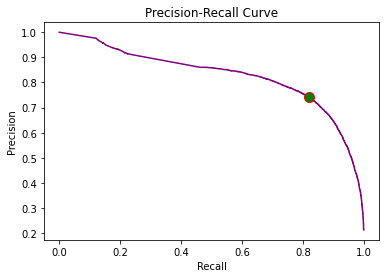

In [ ]:
# Precision Recall Curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, thresholds = precision_recall_curve(y_train, train_preds_proba_GBC)

f1_scores = 2*recall*precision/(recall+precision)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))
print('Index of Max F1:', np.argmax(f1_scores))
print('Average Precision Score (Area Under PR Curve):', average_precision_score(y_train, train_preds_GBC))
optimal_threshold_PR=thresholds[np.argmax(f1_scores)]
optimal_idx = np.argmax(f1_scores)

#creating precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#plotting optimal point
ax.plot(recall[optimal_idx], precision[optimal_idx], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")

#adding axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

### ROC Curve and optimal classification threshold for train predictions

index of optimal threshold: 3534
optimal probability threshold: 0.21721134727440794
fpr coordinate: 0.11933696401816928
tpr coordinate: 0.8903469351069567
AUC: 0.947468218932085


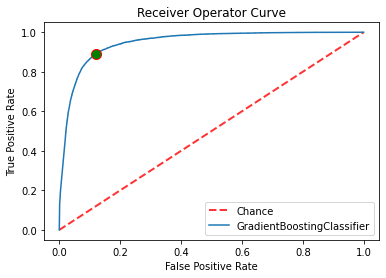

In [ ]:
# ROC Curve for train

# Calculate necessary ROC Curve elements
fpr_train, tpr_train, thresholds = roc_curve(y_train,train_preds_proba_GBC )


optimal_idx = np.argmax(tpr_train - fpr_train)
optimal_threshold_ROC = thresholds[optimal_idx]

print(f'index of optimal threshold: {optimal_idx}')
print(f'optimal probability threshold: {optimal_threshold_ROC}')
print(f'fpr coordinate: {fpr_train[optimal_idx]}')
print(f'tpr coordinate: {tpr_train[optimal_idx]}')
print(f'AUC: {auc(fpr_train, tpr_train)}')

#create ROC curve for train

plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.plot(fpr_train,tpr_train,label="GradientBoostingClassifier")
plt.plot(fpr_train[optimal_idx], tpr_train[optimal_idx], marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")
plt.title('Receiver Operator Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Prediction on unseen data

In [ ]:
test_preds_GBC = GBC.predict(X_test)

###Prediction probabilities for the test dataset

In [ ]:
test_preds_proba_GBC = GBC.predict_proba(X_test)
test_preds_proba_GBC = test_preds_proba_GBC[:, 1]

In [ ]:
print(confusion_matrix(y_test, test_preds_GBC))
print(f'test set accuracy score: {accuracy_score(y_test, test_preds_GBC)}')

[[9908  605]
 [ 803 1978]]
test set accuracy score: 0.8940875582969761


In [ ]:
# extract TP, TN, FP, FN for test
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, test_preds_GBC).ravel()
(tn_test, fp_test, fn_test, tp_test)

(9908, 605, 803, 1978)

In [ ]:
# precision and recall for '1' class
Precision_test = tp_test / (tp_test + fp_test)
Recall_test = tp_test / (tp_test + fn_test)

Precision_test = round(Precision_test, 2)
Recall_test = round(Recall_test, 2)

print("Precision for train:",Precision_test)
print("Recall for train:", Recall_test)

Precision for train: 0.77
Recall for train: 0.71


### Precision Recall Curve for Test predictions 

Best threshold:  0.3646837611013699
Best F1-Score:  0.7484136511747557
Index of Max F1: 9909
Average Precision Score (Area Under PR Curve): 0.7987422864859262


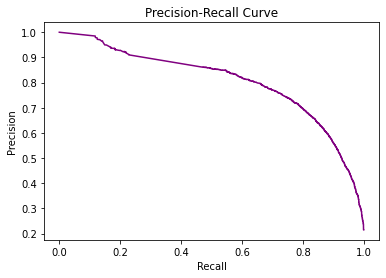

In [ ]:
# Precision Recall Curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test,test_preds_proba_GBC)

f1_scores = 2*recall*precision/(recall+precision)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))
print('Index of Max F1:', np.argmax(f1_scores))
print('Average Precision Score (Area Under PR Curve):', average_precision_score(y_test, test_preds_proba_GBC))
optimal_threshold_PR=thresholds[np.argmax(f1_scores)]
optimal_idx = np.argmax(f1_scores)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

### ROC Curve for test predictions

index of optimal threshold: 1040
optimal probability threshold: 0.20343141052125333
fpr coordinate: 0.13649766955198325
tpr coordinate: 0.862279755483639
AUC: 0.9323329178616993


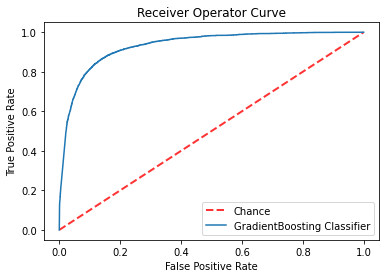

In [ ]:
# ROC Curve for test

# Calculate necessary ROC Curve elements
fpr_test, tpr_test, thresholds = roc_curve(y_test,test_preds_proba_GBC)
optimal_idx = np.argmax(tpr_test - fpr_test)
optimal_threshold_ROC = thresholds[optimal_idx]


print(f'index of optimal threshold: {optimal_idx}')
print(f'optimal probability threshold: {optimal_threshold_ROC}')
print(f'fpr coordinate: {fpr_test[optimal_idx]}')
print(f'tpr coordinate: {tpr_test[optimal_idx]}')
print(f'AUC: {auc(fpr_test, tpr_test)}')

#create ROC curve for test

plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.plot(fpr_test,tpr_test,label="GradientBoosting Classifier")
plt.title('Receiver Operator Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

#Using Precision Recall Optimal Threshold

### Confusion matrix

In [ ]:
#Confusion Matrix at Optimal Point on PR Curve for test
print(confusion_matrix(y_test, GBC.predict_proba(X_test)[:,1] > optimal_threshold_PR))
print('\n')
print(f'test set accuracy score: {accuracy_score(y_test, GBC.predict_proba(X_test)[:,1] > optimal_threshold_PR)}')

[[9634  879]
 [ 598 2183]]


test set accuracy score: 0.888897246878291


### Extracting TP, TN, FP, FN for test predictions

In [ ]:
# extract TP, TN, FP, FN for test
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, GBC.predict_proba(X_test)[:,1] > optimal_threshold_PR).ravel()
(tn_test, fp_test, fn_test, tp_test)

(9634, 879, 598, 2183)

### Precision and Recall for the Test predictions

In [ ]:
# precision and recall for '1' class
# these were defined above
Precision_test = tp_test / (tp_test + fp_test)
Recall_test = tp_test / (tp_test + fn_test)

# round to 2 decimal points
Precision_test = round(Precision_test, 2)
Recall_test = round(Recall_test, 2)

# print
print("Precision for test:",Precision_test)
print("Recall for test:", Recall_test)

Precision for test: 0.71
Recall for test: 0.78


#Using ROC Optimal Threshold

### Confusion matrix for optimal threshold

In [ ]:
#Confusion Matrix at Optimal Point on ROC Curve for test
print(confusion_matrix(y_test, GBC.predict_proba(X_test)[:,1] > optimal_threshold_ROC))
print('\n')
print(f'test set accuracy score: {accuracy_score(y_test, GBC.predict_proba(X_test)[:,1] > optimal_threshold_ROC)}')

[[9152 1361]
 [ 405 2376]]


test set accuracy score: 0.8671581164435084


### Extracting TP, TN, FP, FN for test predictions

In [ ]:
# extract TP, TN, FP, FN for test
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, GBC.predict_proba(X_test)[:,1] > optimal_threshold_PR).ravel()
(tn_test, fp_test, fn_test, tp_test)

(9634, 879, 598, 2183)

### Precision and Recall for the Test predictions

In [ ]:
# precision and recall for '1' class
Precision_test = tp_test / (tp_test + fp_test)
Recall_test = tp_test / (tp_test + fn_test)
Precision_test = round(Precision_test, 2)
Recall_test = round(Recall_test, 2)

print("Precision for test:",Precision_test)
print("Recall for test:", Recall_test)

Precision for test: 0.71
Recall for test: 0.78


1. Using Precision Recall Optimal Classification Threshold
  * Accuracy Score: 0.8863
  * Precision: 0.71
  * Recall: 0.77
2. Using ROC Optimal Classification Threshold
  * Accuracy Score: 0.8610
  * Precision: 0.71
  * Recall: 0.77


### These are the final scores after completing all the models and hyper parameter tuning for the best model. The optimal threshold has been found and the confusion matrix and other metrics have been found for the same. The AUC is high and that says that the model is very good and same with train and test accuracy, precision, recall values. 

### Train:

Accuracy: 90.4%

Precision: 0.79

Recall: 0.74

Area under PRC: 0.63, optimal threshold: 0.36

Area under ROC: 0.94, optimal threshold: 0.21

### Test:

Accuracy: 89.34%

Precision: 0.76
 
Recall: 0.71

Area under PRC: 0.79

Area under ROC: 0.93


### Feature Importance

In [ ]:
# from sklearn.inspection import permutation_importance
# clf = GBC

# result = permutation_importance(clf, X_test, y_test, n_repeats=10,
#                                 random_state=42)
# perm_sorted_idx = result.importances_mean.argsort()

# tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
# tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

# fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
# ax1.boxplot(result.importances[perm_sorted_idx].T, vert=False,
#             labels=X.columns[perm_sorted_idx])
# fig.suptitle('GBC Feature Importance', y=1.05)
# fig.tight_layout()
# plt.show()

### The most important features for the model are 

1) user_account_balance_last_8

2) calls_outgoing_count_7

3) sms_outgoing_to_abroad_inactive_days_7

4) user_lifetime_8

### Preparing the data for finding business insights

In [ ]:
df_new1 = pd.concat([df_6_new,df_7_new,df_8_new], axis=1, join='outer')


In [ ]:
column=list(df_new1.select_dtypes(['int64','float64','object']).columns)
df_new1[column] = df_new1[column].fillna(df_new1[column].median())

In [ ]:
df_new = pd.concat([df_new1,df2], axis=1, join='inner')

### Business Insights

### 1. Here, we have plotted a graph between user_intake for all months, churn, grprs usage for all months and gprs spendings for all months. For months 6 and 7, the old customers and those who are staying back, the spendings are increasing with their usage of gprs for  most of the customers. Where as for month 8, most of their spendings were not increasing and they were constant. For the old customers and for who left,  the increase in spendings is high with a small increase in gprs usage.

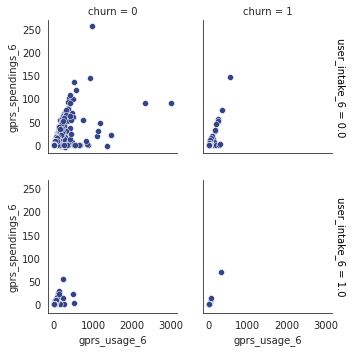

In [ ]:
with sns.axes_style("white"):
    g = sns.FacetGrid(df_new, row="user_intake_6", col="churn", margin_titles=True, height=2.5)
g.map(sns.scatterplot, "gprs_usage_6", "gprs_spendings_6", color="#334488")
g.figure.subplots_adjust(wspace=.2, hspace=.2)
g.set_titles('sms usage vs sms spendings')

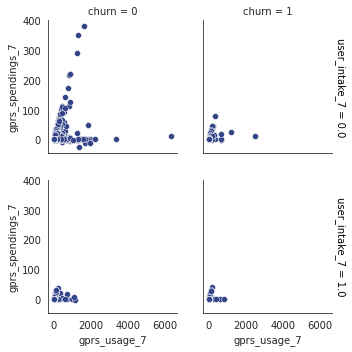

In [ ]:
with sns.axes_style("white"):
    g = sns.FacetGrid(df_new, row="user_intake_7", col="churn", margin_titles=True, height=2.5)
g.map(sns.scatterplot, "gprs_usage_7", "gprs_spendings_7", color="#334488")
g.figure.subplots_adjust(wspace=.2, hspace=.2)
g.set_titles('sms uasge vs sms spendings')

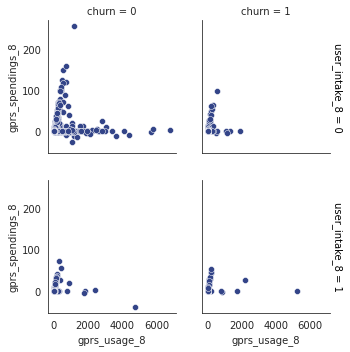

In [ ]:
with sns.axes_style("white"):
    g = sns.FacetGrid(df_new, row="user_intake_8", col="churn", margin_titles=True, height=2.5)
g.map(sns.scatterplot, "gprs_usage_8","gprs_spendings_8", color="#334488")
g.figure.subplots_adjust(wspace=.2, hspace=.2)
g.set_titles('sms usage vs sms spendings')

### 2. We can see that, just before the customers left their spendings have decreased comparitevly. So, this might be a trend or sign to predict the time they cancel their subscription.

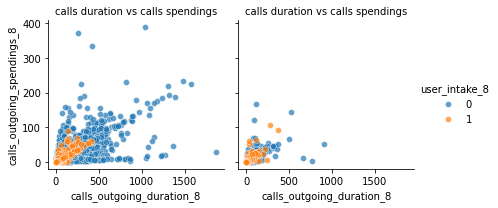

In [ ]:
g = sns.FacetGrid(df_new, col="churn", hue="user_intake_8")
g.map(sns.scatterplot,"calls_outgoing_duration_8", "calls_outgoing_spendings_8", alpha=.7)
g.add_legend()
g.set_titles('calls duration vs calls spendings')

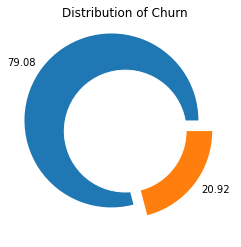

In [ ]:
data = df_new.churn.value_counts().values
total = sum(data)
data_per = data/total*100
explode = (0.2, 0)
plt.pie(data_per, explode = explode, labels = [round(i,2) for i in (list(data_per))])
circle = plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(circle)
plt.title('Distribution of Churn')
plt.show()
